# Geometry and Inheritance

Let us consider the case where instead of a sphere in fission, our $^{235}$U sample was a cylinder.  What would change?  

We only need to change Geometry.NextInteraction, to calculate interactions with a cylinder instead ofa  sphere and ThrowPositions, to generate positions inside a cylinder instead of inside a sphere.

Python uses "inheritance" to accomplish this, so we can "tinker" with classes and enable them to perform related but different functions.  

We define a new class, Cylinder, that inherits from Geometry.

For Next interaction, we need to solve for four possible distance values: the distances to the top and bottom planes, and the distance to the (2) intersections with the cylindrical face:

$(\vec{x}+d\hat{n})\cdot\hat{a}=\pm h$ for the top and bottom faces, where $\hat{a}$ is the cylinder axis and $h$ is the height of the cylinder.

In general (for arbitrary orientation of the cylinder) the solution for the intersection of a line with a cylinder of radius r is:
\begin{equation}\left((\vec{x}+d\hat{n})-\left((\vec{x}+d\hat{n})\cdot\hat{a}\right)\hat{a}\right)^2=r^2\end{equation}

Some algebra shows that this is the same as
\begin{equation}d^2(1-(\hat{n}\cdot\hat{a})^2) +2d(\vec{x}\cdot\hat{n}-(\vec{x}\cdot\hat{a})(\hat{n}\cdot\hat{a}))+x^2-(\vec{x}\cdot\hat{a})^2-r^2=0  \end{equation}

While we are at it, we will add a "cylindricaL" helper function (outside of Cylinder), to convert from (x,y,z) to (z,rho,phi)

In [3]:
import fissionMC as fmc  #allows us to change geo
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

class Cylinder(fmc.Geometry):
    '''This class provides alternative functionality to allow the fission mass to be cylindrical'''
    def ThrowPositions(self): # throws positions within a cylinder
        self.position=0
        rho=self.radius*np.sqrt(np.random.rand(self.throwN)) #throw cylindrical radius
        z=self.height*(np.random.rand(self.throwN)-0.5)
        phi=2*np.pi*np.random.rand(self.throwN)
        self.positions=np.array([rho*np.cos(phi),rho*np.sin(phi),z]).transpose()
        
        
    def NextInteraction(self,neutron):
        '''This routine checks for the next intersection the cylinder, or where the next nuclear interaction 
        will happen
        NextInteraction determines whether the neutron leaves the sphere, fissions, elastically scatters.  
        it returns with the time to the interaction and a tuple that contains information about outgoing neutrons
        for fissions interaction contains the number of daughters
        for geometrical events or when there are zero neutrons generated, interaction is empty'''
        
        #solve for the distance to the cylindrical surface
        #for cylindrical surface set up a*d^2+bd+c=0
        
        na=np.dot(neutron.direction,self.axis)
        xn=np.dot(neutron.position,neutron.direction)
        xa=np.dot(neutron.position, self.axis)
        x2=np.dot(neutron.position,neutron.position)
        
#        import pdb; pdb.set_trace
        d=np.roots(np.array([1-na*na,2*(xn-xa*na), x2-xa*xa-self.radius**2]))
        if na != 0:
            d2=np.array([(self.height/2-xa)/na, (-self.height/2-xa)/na])
            d=np.concatenate((d,d2))
                   
        dpos=1e10  #distance to next interaction
        for dd in d: #check if the interaction is a geometrical border crossing  
            if dd>0 and dd<dpos:
                dpos=dd
        if dpos==1e10:
            print('Error.  Tried finding roots when outside the cylinder')
            
        #now check for neutron interactions
        elastic,dist, interactionOutput=self.mat.interaction(neutron.energy)  # returns the mean distance and the energies of the outgoing neutrons
        dd=np.random.exponential(dist)
        if dpos<dd:   #neutron escapes
            elastic=False
            interactionOutput=()
        else:
            dpos=dd
        time=dpos/neutron.velocity
        return (time,elastic,interactionOutput)

        
    def __init__(self,label):
        super().__init__(label)  #initialize the rest inside the base class
        if 'cylinder' in label:
            self.height=25.0  #cm height
            self.radius=8.0  #cm radius
            self.axis=np.array([0,0,1])
            print('Initializing cylindrical geometry radius %f cm, height %f cm, mass %f kg'%
                  (self.radius,self.height,np.pi*self.radius**2*self.height*self.mat.density*1e-3))
            
def cylindrical(x):
        '''conversion from Cartesian to cylindrical (z, rho, phi) coordinates.  Why is it not already in numpy?''' 
        rho=np.sqrt(x[0]**2+x[1]**2)
        phi=np.arctan2(x[1],x[0])
#        import pdb; pdb.set_trace()
        return (x[2],rho,phi)
        
        

In [4]:
fmc.geo=Cylinder('cylinder')
n=fmc.Neutron()

Starting to initialize U235
Initializing cylindrical geometry radius 8.000000 cm, height 25.000000 cm, mass 94.796898 kg


In [5]:
fmc.geo.radius=8.0
fmc.geo.height=16.0

exitPositions=[] # where neutrons leave the sphere
startPositions=[] #where mothers are generated
fissionPositions=[] #where fissions occur
number=[]  #number of neutrons


fmc.Neutron.output=False #turn off print statements

trange=np.arange(0,fmc.Neutron.maxTime, fmc.Neutron.timeBin)
neutrons=np.zeros(fmc.Neutron.numberOfBins)

for run in range(1,2000):
#    pdb.set_trace()
    n.TrackNeutrons(10000000)
    startPositions.append(cylindrical(fmc.Neutron.firstNeutronStartPosition))
    count=0
    for i in range (0,fmc.Neutron.numberOfBins):
        for j in range(0,len(fmc.Neutron.list[i])):
            count+=1
            nn=fmc.Neutron.list[i][j]
            d=nn.nDaughters
            if 'escape' in d:
                exitPositions.append(cylindrical(nn.position))
            else:
                fissionPositions.append(cylindrical(nn.position))
            #now increment the neutrons versus time
            t1=int(nn.time0/fmc.Neutron.timeBin)
            t2=int(nn.time/fmc.Neutron.timeBin)+1
            if t1>=fmc.Neutron.numberOfBins:
                t1=fmc.Neutron.numberOfBins-1
            if t2>fmc.Neutron.numberOfBins:
                t2=fmc.Neutron.numberOfBins
            for t in range(t1,t2):
                neutrons[t]+=1
    
    number.append(count)
    if run%5 ==0:
        print('Run #',run)

#now we convert the lists into np arrays with rows corresponding to r, ctheta,phi
startPositions=np.array(startPositions).transpose()
exitPositions=np.array(exitPositions).transpose()
fissionPositions=np.array(fissionPositions).transpose()
number=np.array(number)



Run # 5
Run # 10
Run # 15
Run # 20
Run # 25
Run # 30
Run # 35
Run # 40
Run # 45
Run # 50
Run # 55
Run # 60
Run # 65
Run # 70
Run # 75
Run # 80
Run # 85
Run # 90
Run # 95
Run # 100
Run # 105
Run # 110
Run # 115
Run # 120
Run # 125
Run # 130
Run # 135
Run # 140
Run # 145
Run # 150
Run # 155
Run # 160
Run # 165
Run # 170
Run # 175
Run # 180
Run # 185
Run # 190
Run # 195
Run # 200
Run # 205
Run # 210
Run # 215
Run # 220
Run # 225
Run # 230
Run # 235
Run # 240
Run # 245
Run # 250
Run # 255
Run # 260
Run # 265
Run # 270
Run # 275
Run # 280
Run # 285
Run # 290
Run # 295
Run # 300
Run # 305
Run # 310
Run # 315
Run # 320
Run # 325
Run # 330
Run # 335
Run # 340
Run # 345
Run # 350
Run # 355
Run # 360
Run # 365
Run # 370
Run # 375
Run # 380
Run # 385
Run # 390
Run # 395
Run # 400
Run # 405
Run # 410
Run # 415
Run # 420
Run # 425
Run # 430
Run # 435
Run # 440
Run # 445
Run # 450
Run # 455
Run # 460
Run # 465
Run # 470
Run # 475
Run # 480
Run # 485
Run # 490
Run # 495
Run # 500
Run # 505
Run # 510


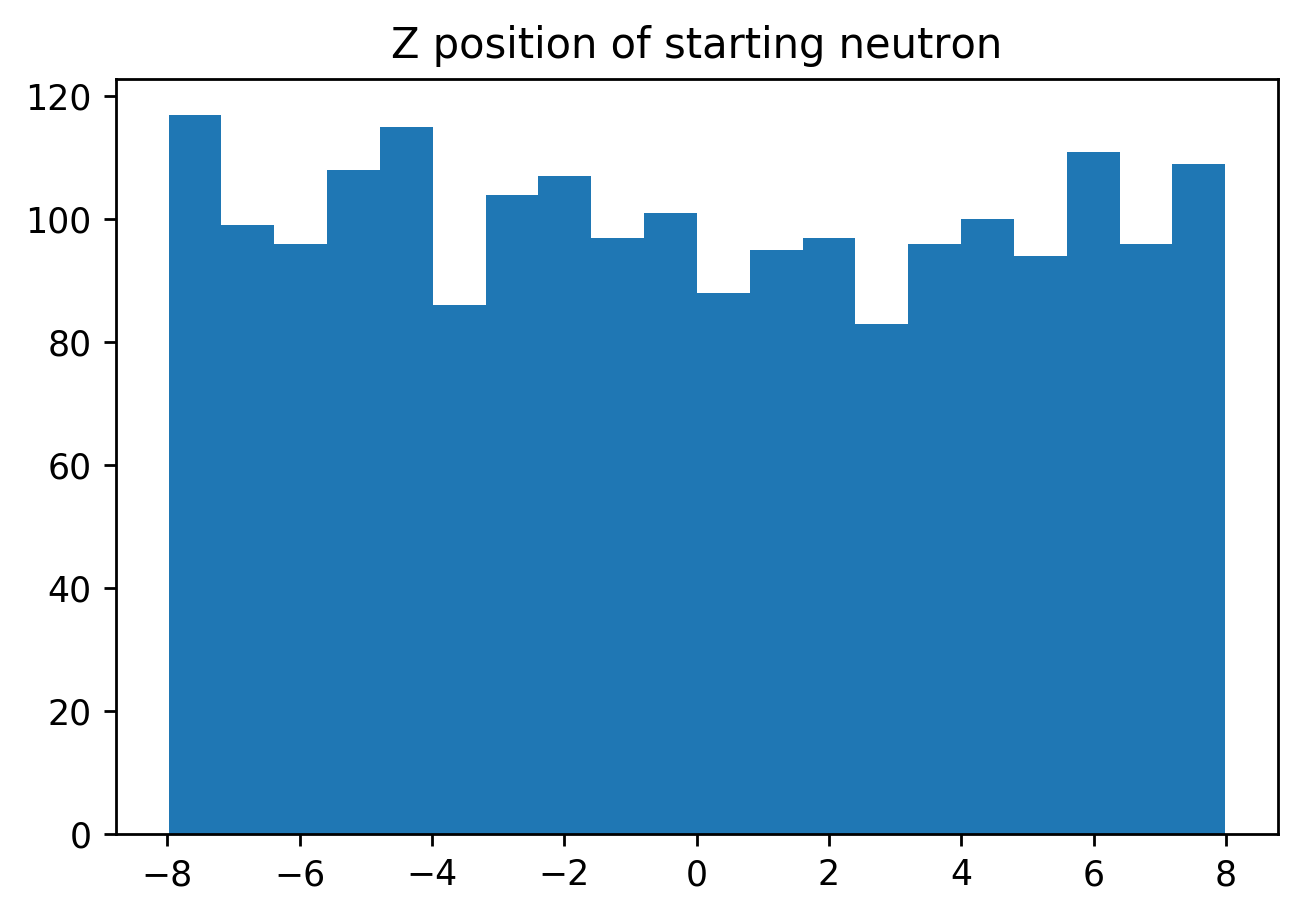

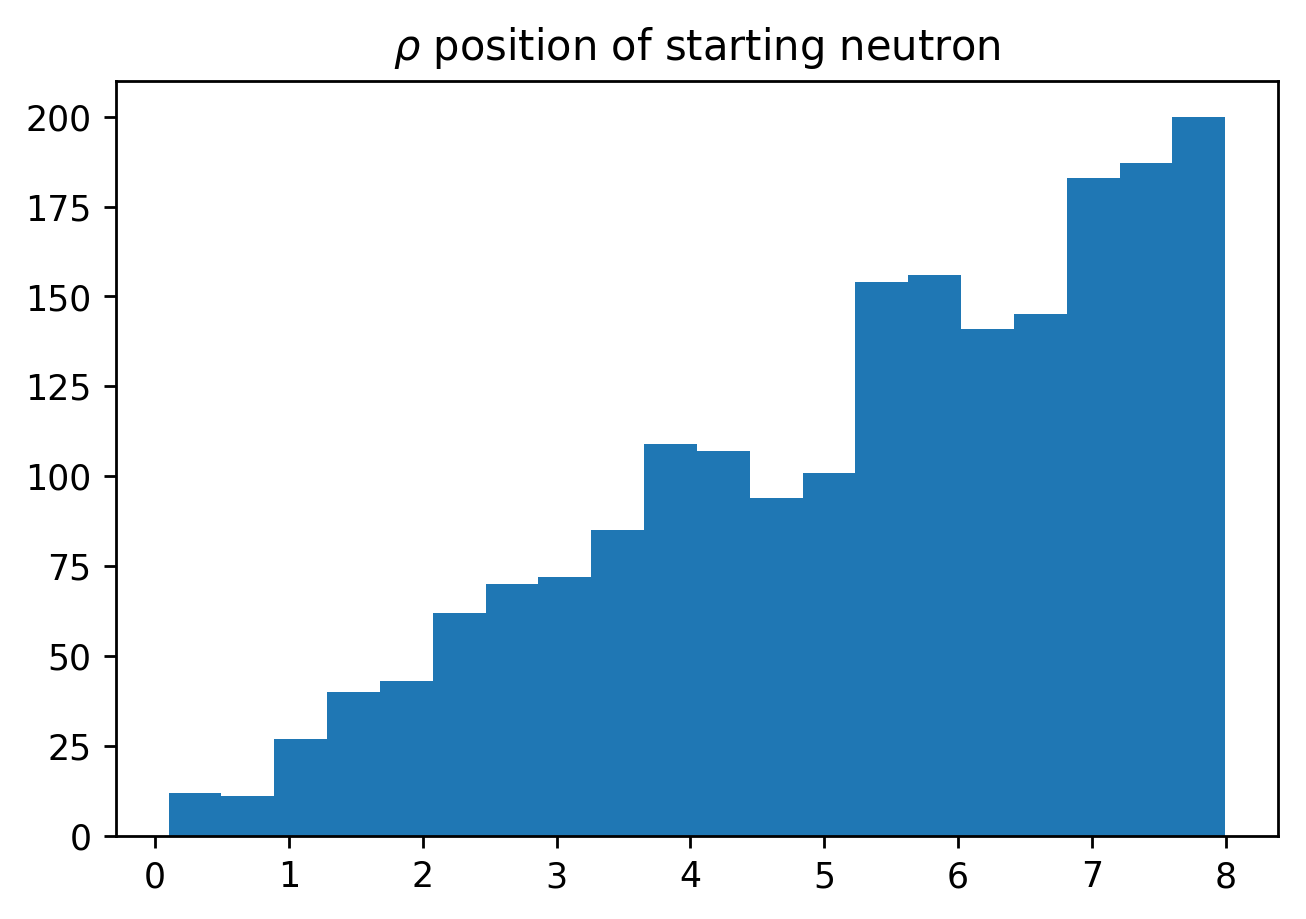

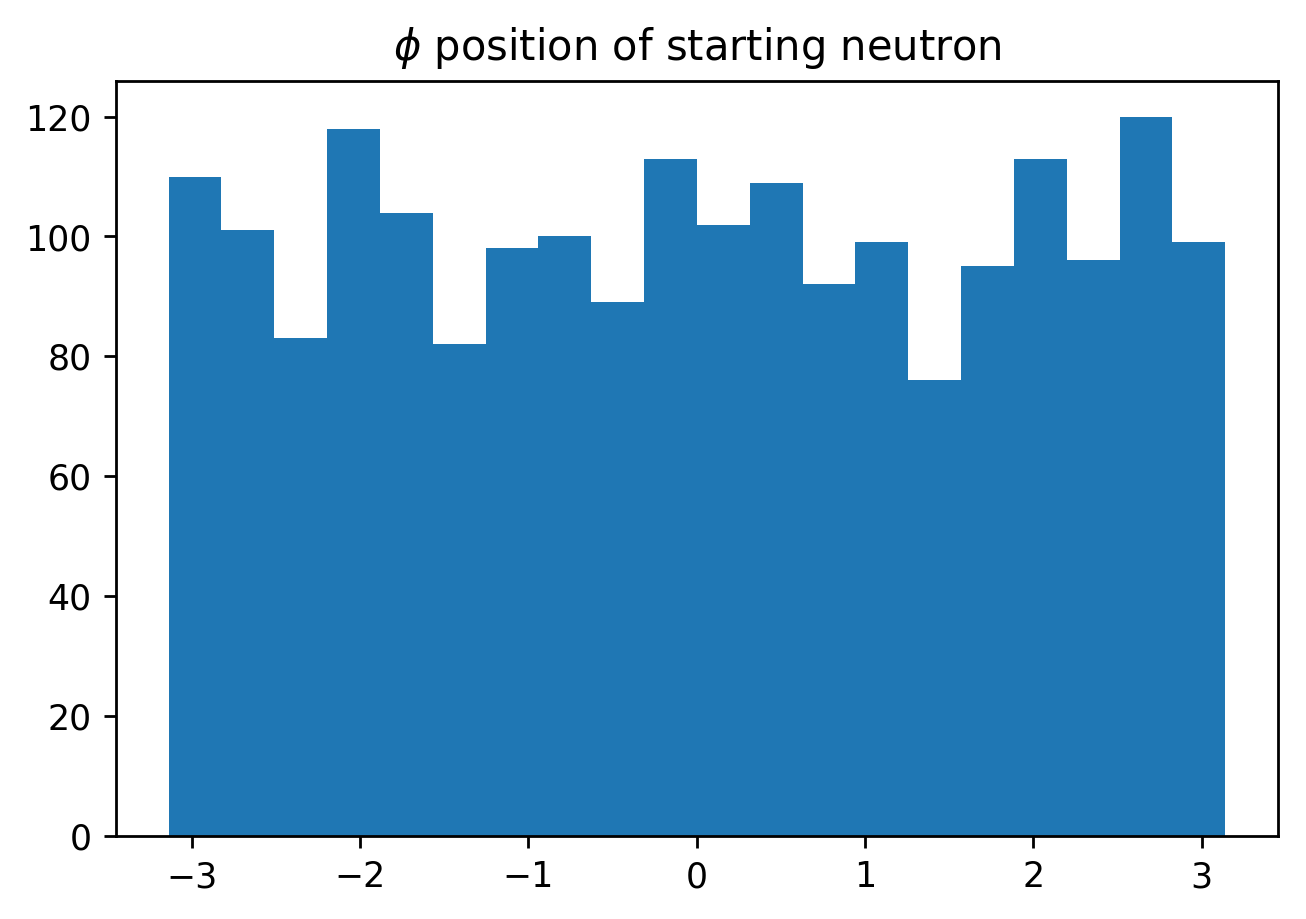

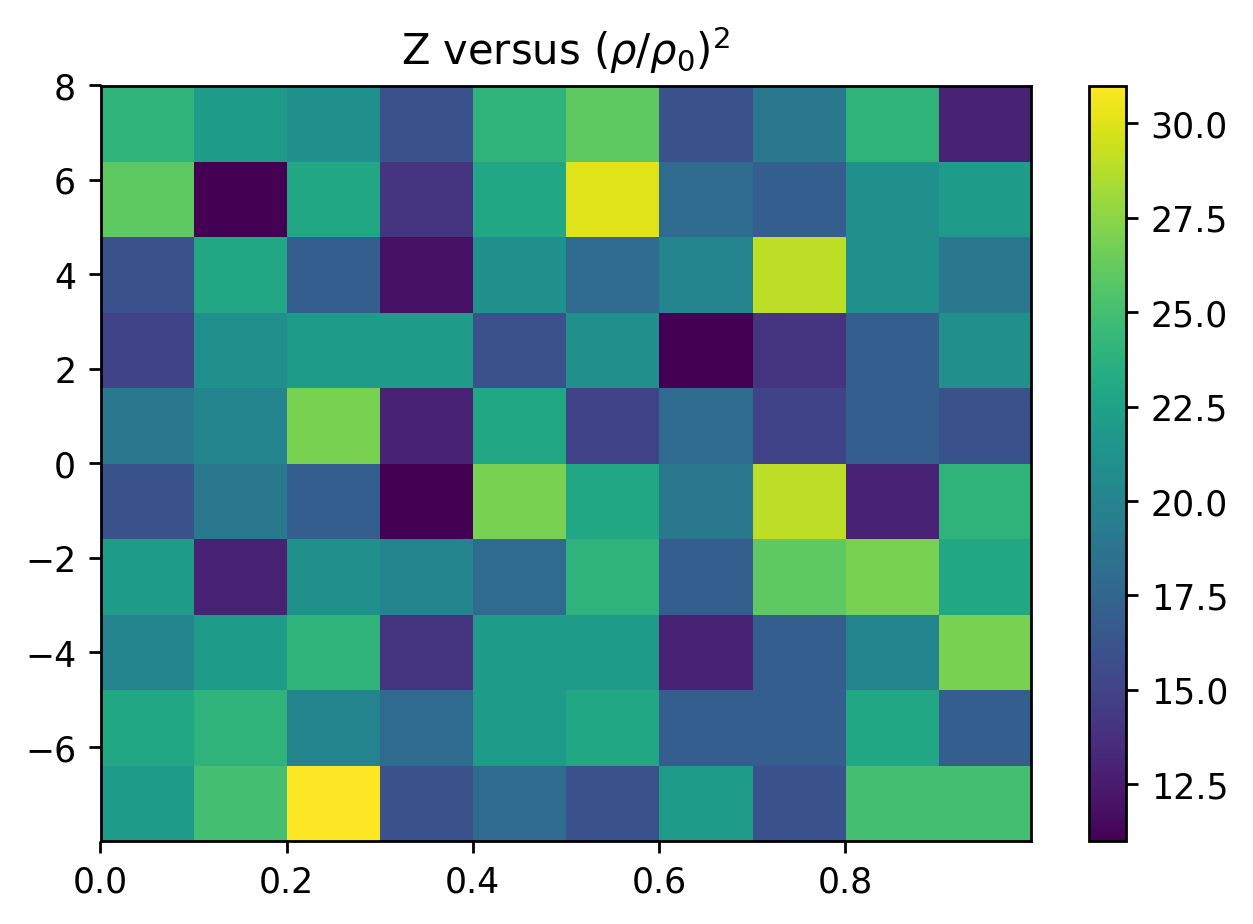

In [4]:
plt.figure()
plt.hist(startPositions[0],20)
plt.title("Z position of starting neutron")
plt.figure()
plt.hist(startPositions[1],20)
plt.title(r'$\rho$ position of starting neutron')
plt.figure()
plt.hist(startPositions[2],20)
plt.title(r'$\phi$ position of starting neutron')

plt.figure()
plt.title(r'Z versus $(\rho/\rho_0)^2$')
plt.hist2d((startPositions[1]/fmc.geo.radius)**2,startPositions[0])
plt.colorbar()

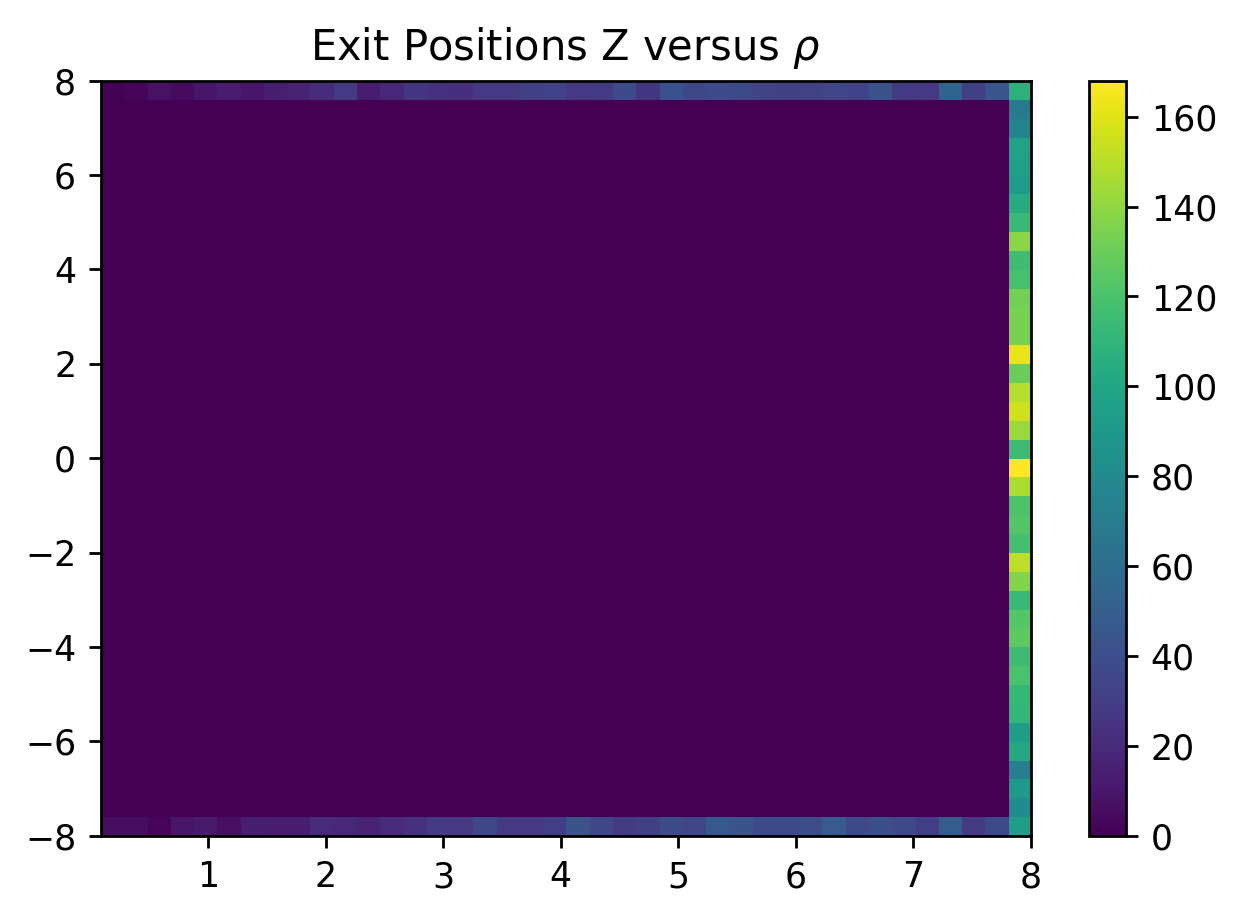

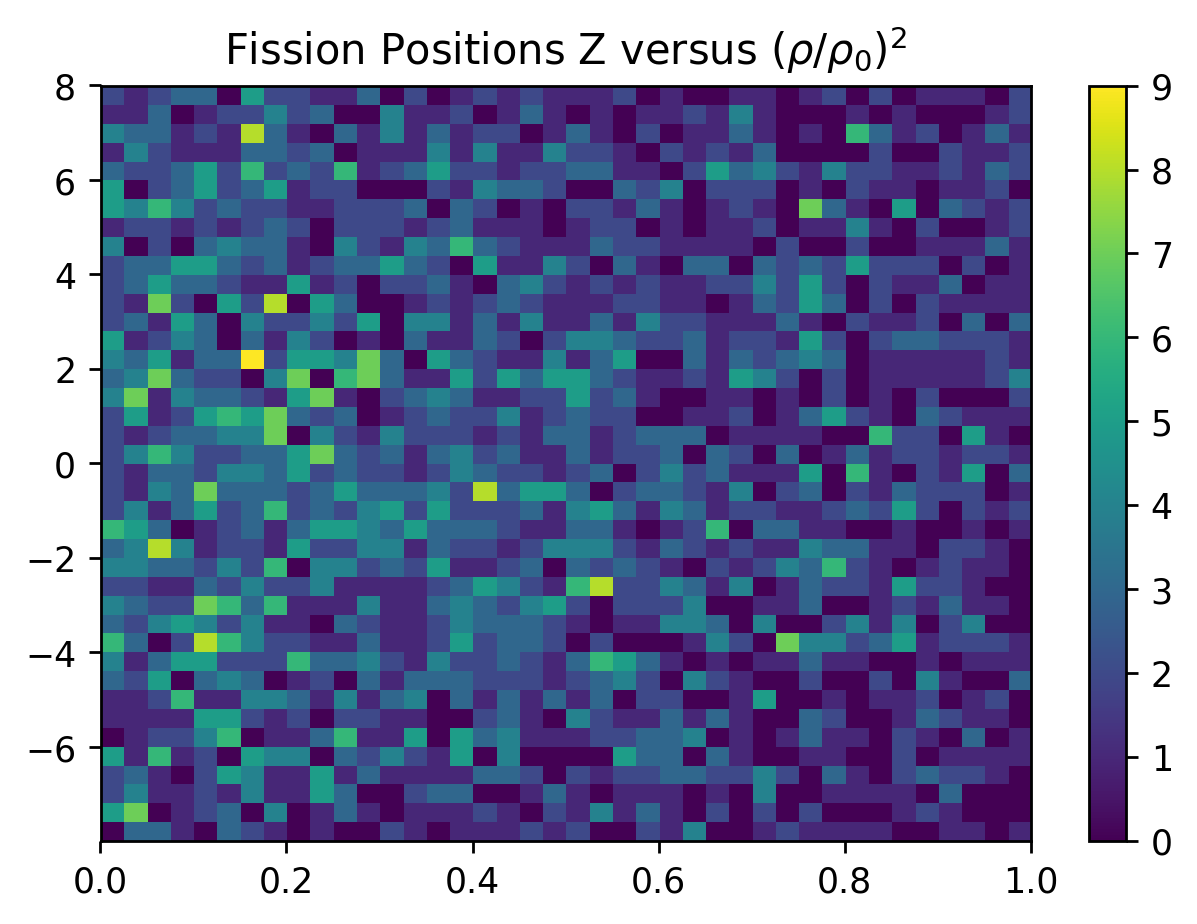

In [5]:
plt.figure()
plt.title(r'Exit Positions Z versus $\rho$')
plt.hist2d(exitPositions[1],exitPositions[0],bins=[40,40])
plt.colorbar()
plt.figure()
plt.title(r'Fission Positions Z versus $(\rho/\rho_0)^2$')
plt.hist2d((fissionPositions[1]/fmc.geo.radius)**2,fissionPositions[0],bins=[40,40])
plt.colorbar()

Number of neutrons 9107


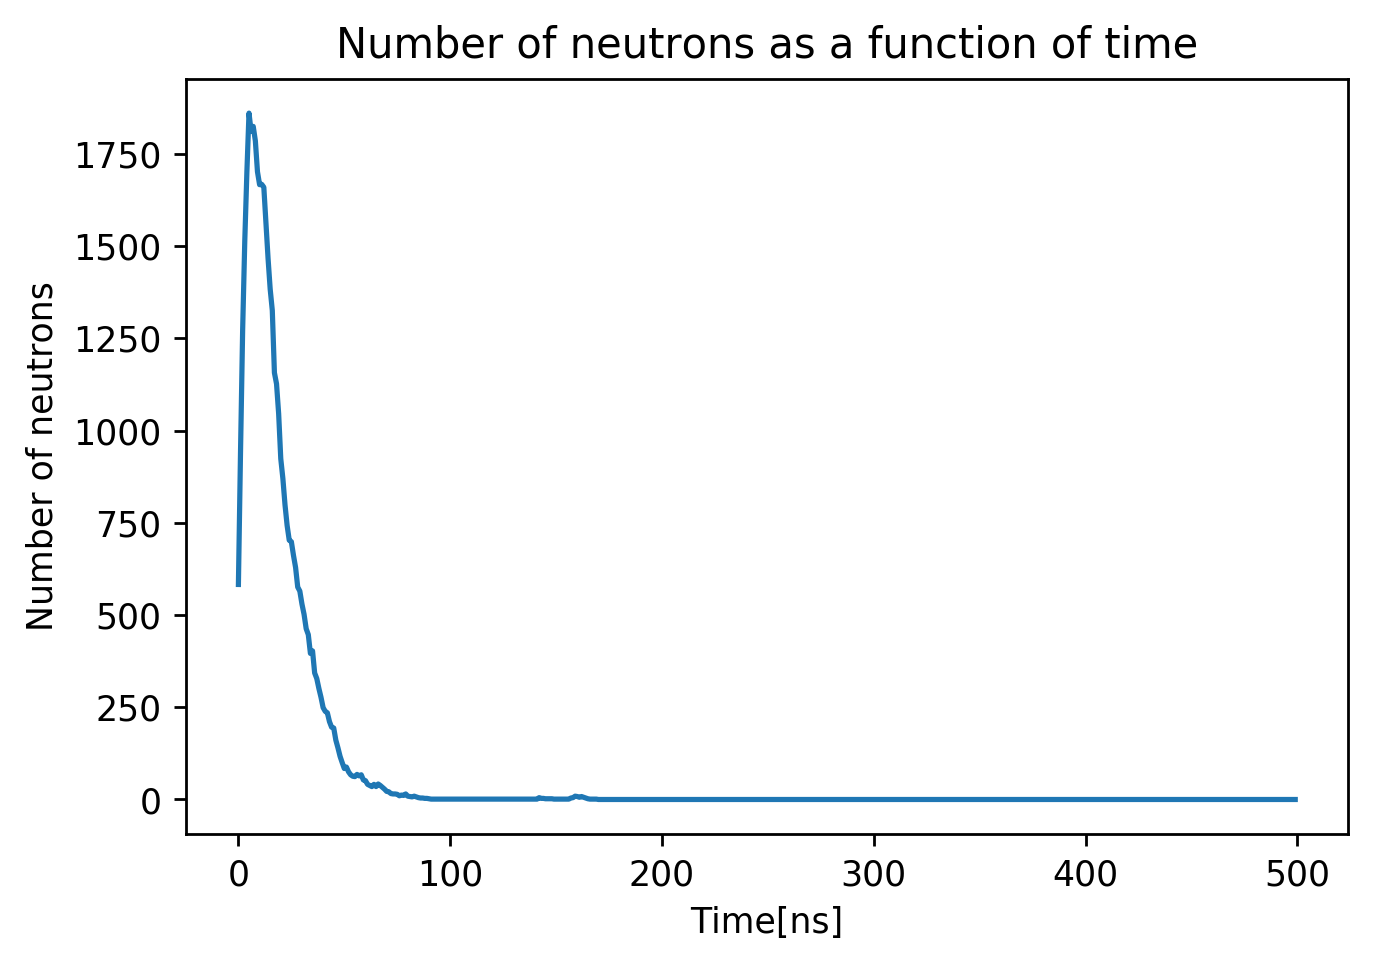

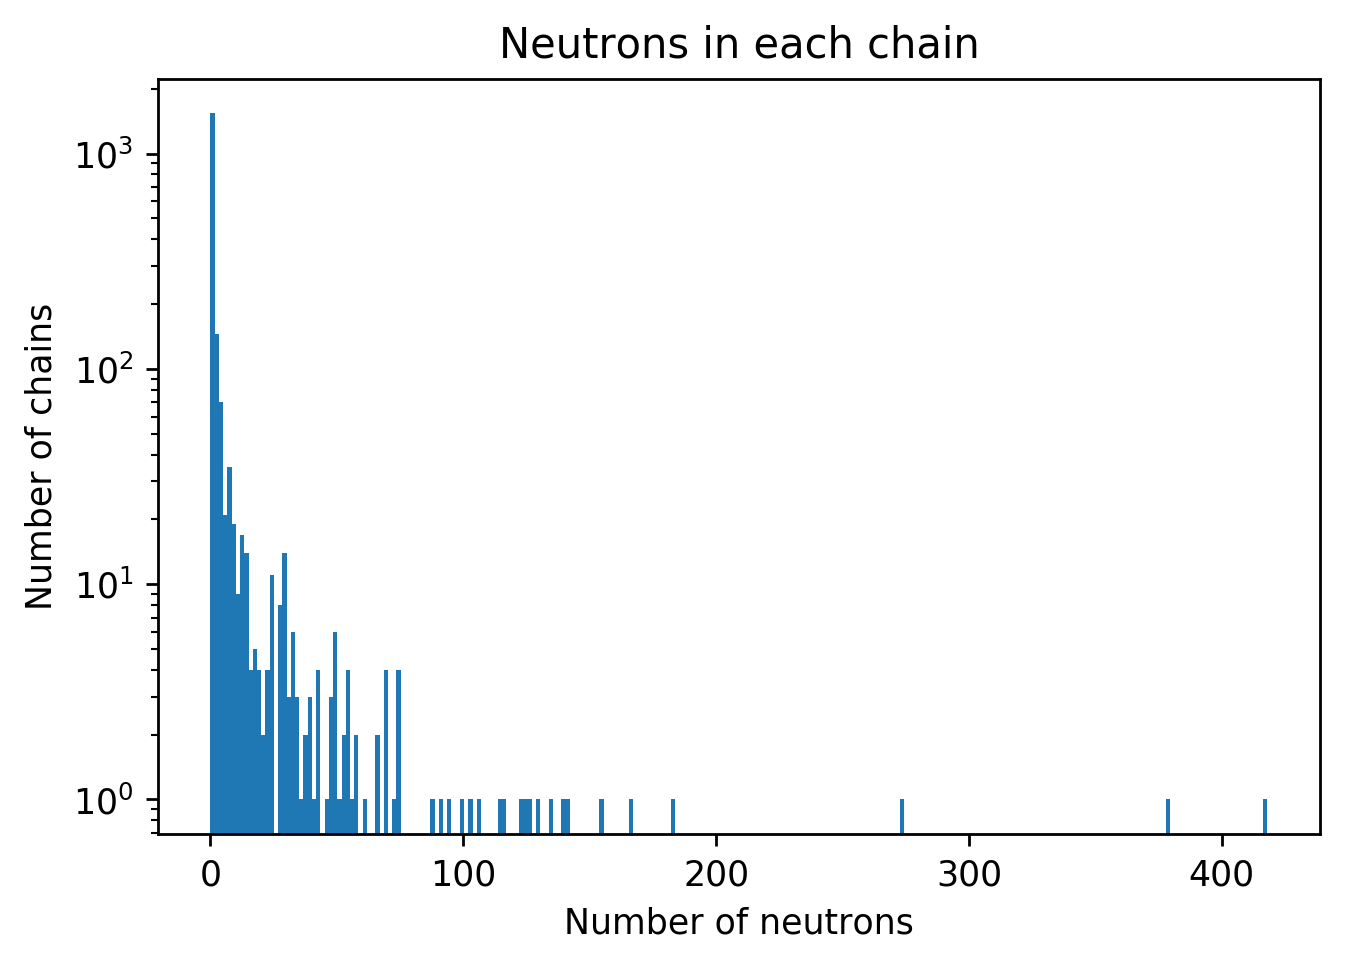

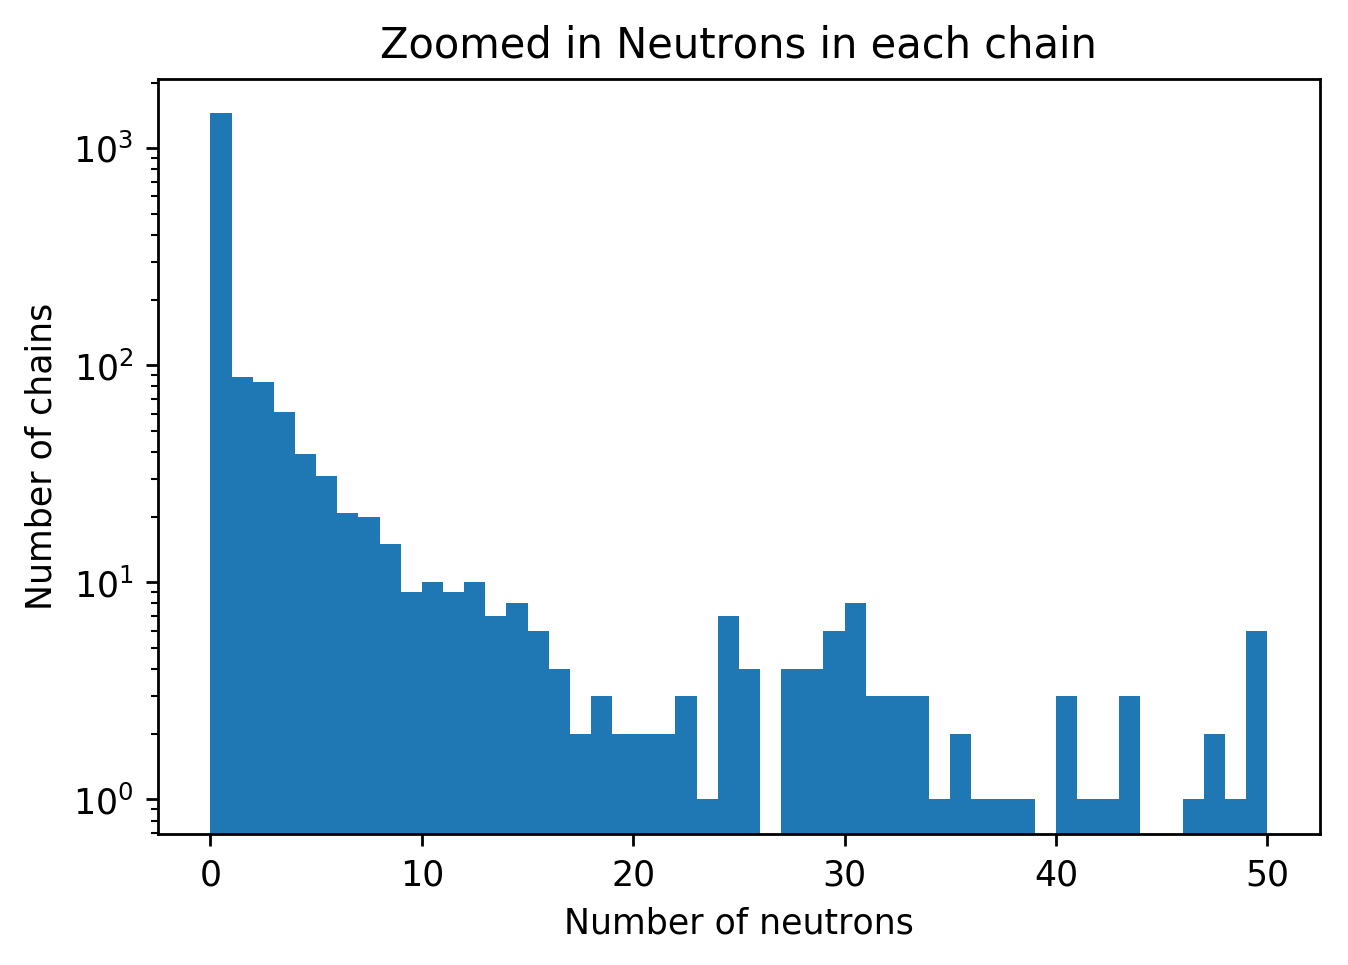

In [6]:
plt.figure()
plt.plot(trange,neutrons)
plt.title ('Number of neutrons as a function of time')
plt.xlabel('Time[ns]')
plt.ylabel('Number of neutrons')
plt.figure()
plt.hist(number,250)
plt.title("Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
plt.figure()
plt.hist(number,50,range=(0,50))
plt.title("Zoomed in Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
print('Number of neutrons', np.sum(number))

Clearly we are below critical mass here.  Let's increase the dimensions and replot. 

In [7]:
fmc.geo.radius=8.0
fmc.geo.height=18.0

print('Mass is',np.pi*fmc.geo.radius**2*fmc.geo.height*1e-3*fmc.geo.mat.density)

exitPositions=[] # where neutrons leave the sphere
startPositions=[] #where mothers are generated
fissionPositions=[] #where fissions occur
number=[]  #number of neutrons


fmc.Neutron.output=False #turn off print statements

trange=np.arange(0,fmc.Neutron.maxTime, fmc.Neutron.timeBin)
neutrons=np.zeros(fmc.Neutron.numberOfBins)

for run in range(1,2000):
#    pdb.set_trace()
    n.TrackNeutrons(10000000)
    startPositions.append(cylindrical(fmc.Neutron.firstNeutronStartPosition))
    count=0
    for i in range (0,fmc.Neutron.numberOfBins):
        for j in range(0,len(fmc.Neutron.list[i])):
            count+=1
            nn=fmc.Neutron.list[i][j]
            d=nn.nDaughters
            if 'escape' in d:
                exitPositions.append(cylindrical(nn.position))
            else:
                fissionPositions.append(cylindrical(nn.position))
            #now increment the neutrons versus time
            t1=int(nn.time0/fmc.Neutron.timeBin)
            t2=int(nn.time/fmc.Neutron.timeBin)+1
            if t1>=fmc.Neutron.numberOfBins:
                t1=fmc.Neutron.numberOfBins-1
            if t2>fmc.Neutron.numberOfBins:
                t2=fmc.Neutron.numberOfBins
            for t in range(t1,t2):
                neutrons[t]+=1
    
    number.append(count)
    if run%5 ==0:
        print('Run #',run)

#now we convert the lists into np arrays with rows corresponding to r, ctheta,phi
startPositions=np.array(startPositions).transpose()
exitPositions=np.array(exitPositions).transpose()
fissionPositions=np.array(fissionPositions).transpose()
number=np.array(number)



Mass is 68.25376679300307
Run # 5
Run # 10
Run # 15
Run # 20
Run # 25
Run # 30
Run # 35
Run # 40
Run # 45
Run # 50
Run # 55
Run # 60
Run # 65
Run # 70
Run # 75
Run # 80
Run # 85
Run # 90
Run # 95
Run # 100
Run # 105
Run # 110
Run # 115
Run # 120
Run # 125
Run # 130
Run # 135
Run # 140
Run # 145
Run # 150
Run # 155
Run # 160
Run # 165
Run # 170
Run # 175
Run # 180
Run # 185
Run # 190
Run # 195
Run # 200
Run # 205
Run # 210
Run # 215
Run # 220
Run # 225
Run # 230
Run # 235
Run # 240
Run # 245
Run # 250
Run # 255
Run # 260
Run # 265
Run # 270
Run # 275
Run # 280
Run # 285
Run # 290
Run # 295
Run # 300
Run # 305
Run # 310
Run # 315
Run # 320
Run # 325
Run # 330
Run # 335
Run # 340
Run # 345
Run # 350
Run # 355
Run # 360
Run # 365
Run # 370
Run # 375
Run # 380
Run # 385
Run # 390
Run # 395
Run # 400
Run # 405
Run # 410
Run # 415
Run # 420
Run # 425
Run # 430
Run # 435
Run # 440
Run # 445
Run # 450
Run # 455
Run # 460
Run # 465
Run # 470
Run # 475
Run # 480
Run # 485
Run # 490
Run # 495
Run 

Number of neutrons 10999


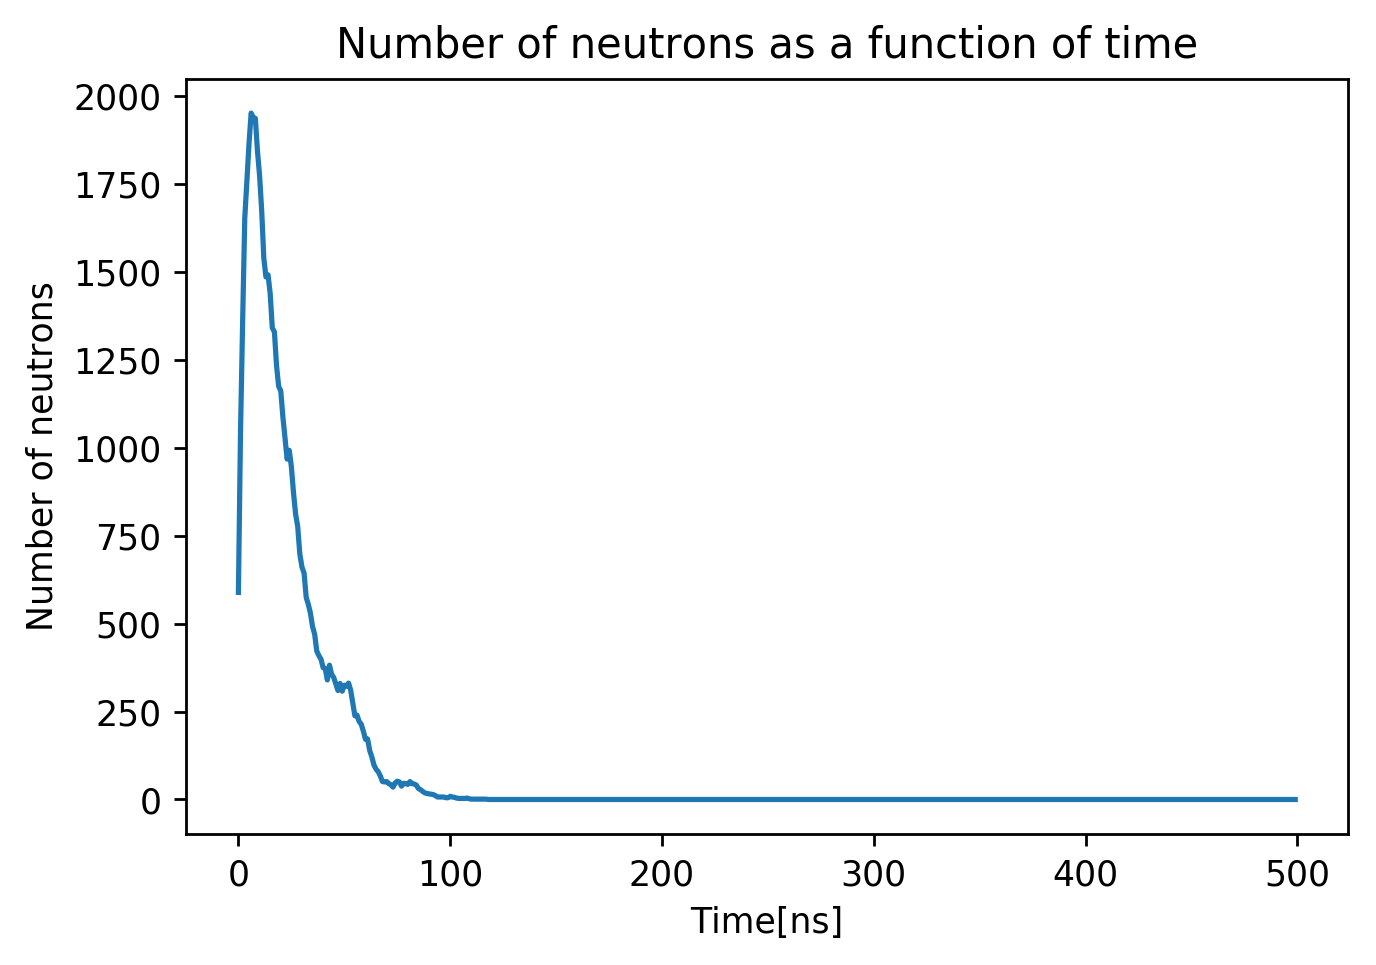

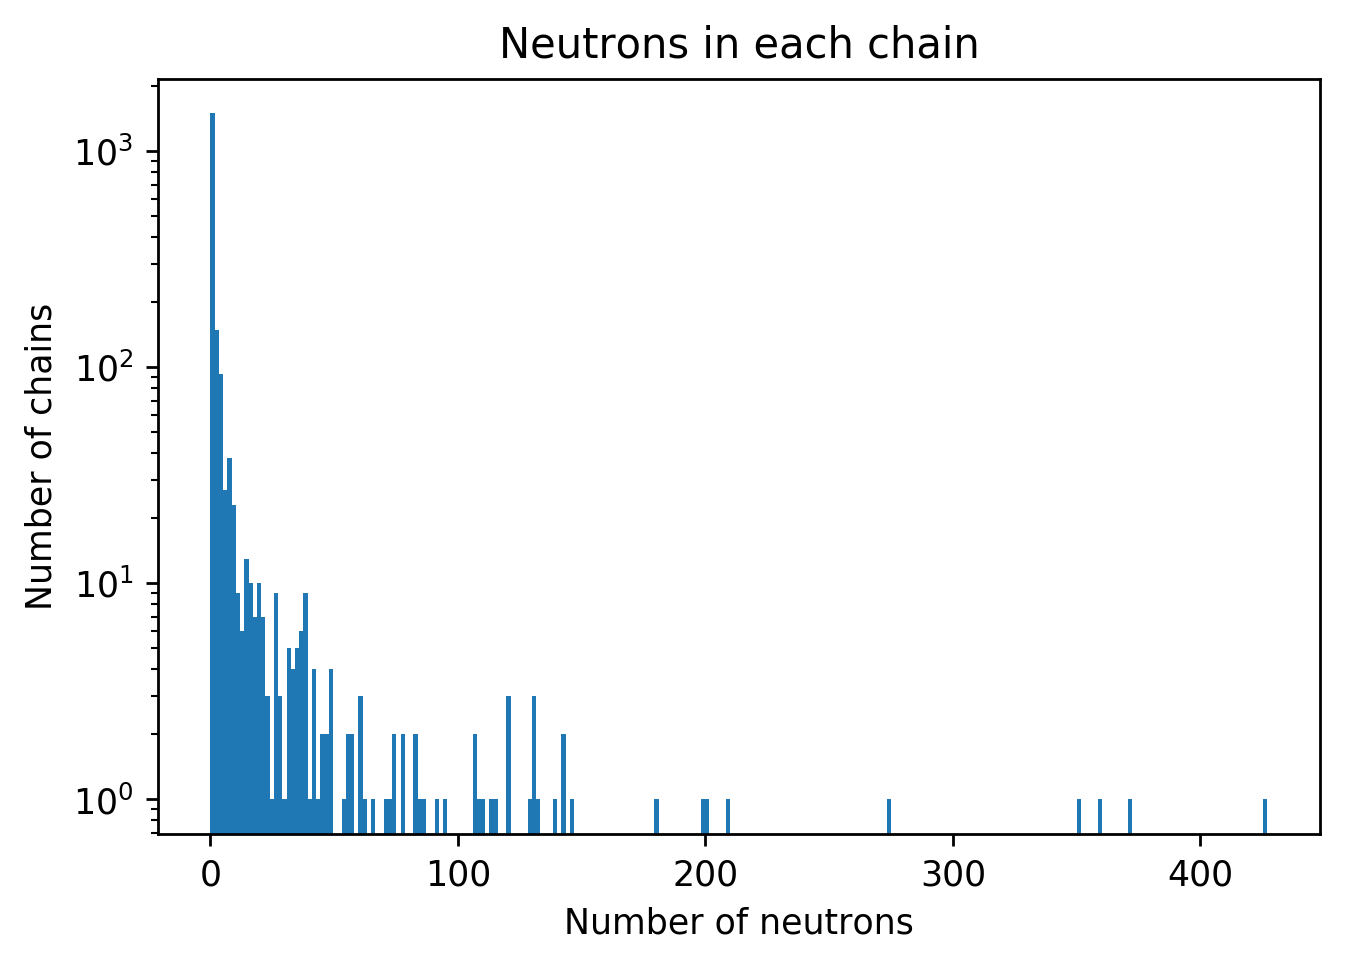

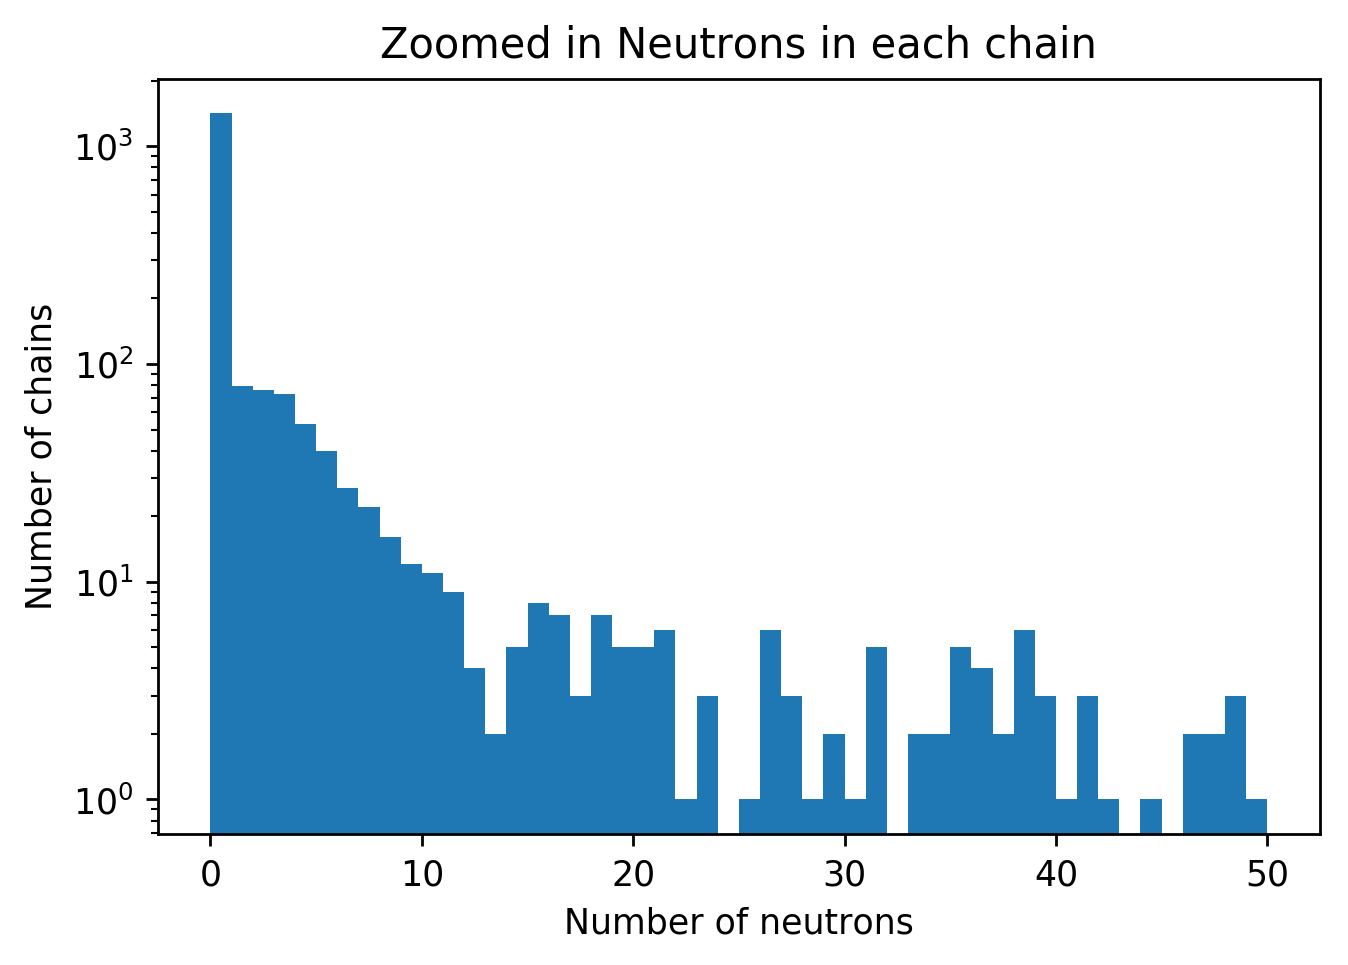

In [8]:
plt.figure()
plt.plot(trange,neutrons)
plt.title ('Number of neutrons as a function of time')
plt.xlabel('Time[ns]')
plt.ylabel('Number of neutrons')
plt.figure()
plt.hist(number,250)
plt.title("Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
plt.figure()
plt.hist(number,50,range=(0,50))
plt.title("Zoomed in Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
print('Number of neutrons', np.sum(number))

Add more mass....

In [9]:
fmc.geo.radius=8.0
fmc.geo.height=26.0

print('Mass is',np.pi*fmc.geo.radius**2*fmc.geo.height*1e-3*fmc.geo.mat.density)

exitPositions=[] # where neutrons leave the sphere
startPositions=[] #where mothers are generated
fissionPositions=[] #where fissions occur
number=[]  #number of neutrons


fmc.Neutron.output=False #turn off print statements

trange=np.arange(0,fmc.Neutron.maxTime, fmc.Neutron.timeBin)
neutrons=np.zeros(fmc.Neutron.numberOfBins)

for run in range(1,2000):
#    pdb.set_trace()
    n.TrackNeutrons(10000000)
    startPositions.append(cylindrical(fmc.Neutron.firstNeutronStartPosition))
    count=0
    for i in range (0,fmc.Neutron.numberOfBins):
        for j in range(0,len(fmc.Neutron.list[i])):
            count+=1
            nn=fmc.Neutron.list[i][j]
            d=nn.nDaughters
            if 'escape' in d:
                exitPositions.append(cylindrical(nn.position))
            else:
                fissionPositions.append(cylindrical(nn.position))
            #now increment the neutrons versus time
            t1=int(nn.time0/fmc.Neutron.timeBin)
            t2=int(nn.time/fmc.Neutron.timeBin)+1
            if t1>=fmc.Neutron.numberOfBins:
                t1=fmc.Neutron.numberOfBins-1
            if t2>fmc.Neutron.numberOfBins:
                t2=fmc.Neutron.numberOfBins
            for t in range(t1,t2):
                neutrons[t]+=1
    
    number.append(count)
    if run%5 ==0:
        print('Run #',run)

#now we convert the lists into np arrays with rows corresponding to r, ctheta,phi
startPositions=np.array(startPositions).transpose()
exitPositions=np.array(exitPositions).transpose()
fissionPositions=np.array(fissionPositions).transpose()
number=np.array(number)



Mass is 98.58877425656
Run # 5
Run # 10
Run # 15
Run # 20
Run # 25
Run # 30
Run # 35
Run # 40
Run # 45
Run # 50
Run # 55
Run # 60
Run # 65
Run # 70
Run # 75
Run # 80
Run # 85
Run # 90
Run # 95
Run # 100
Run # 105
Run # 110
Run # 115
Run # 120
Run # 125
Run # 130
Run # 135
Run # 140
Run # 145
Run # 150
Run # 155
Run # 160
Run # 165
Run # 170
Run # 175
Run # 180
Run # 185
Run # 190
Run # 195
Run # 200
Run # 205
Run # 210
Run # 215
Run # 220
Run # 225
Run # 230
Run # 235
Run # 240
Run # 245
Run # 250
Run # 255
Run # 260
Run # 265
Run # 270
Run # 275
Run # 280
Run # 285
Run # 290
Run # 295
Run # 300
Run # 305
Run # 310
Run # 315
Run # 320
Run # 325
Run # 330
Run # 335
Run # 340
Run # 345
Run # 350
Run # 355
Run # 360
Run # 365
Run # 370
Run # 375
Run # 380
Run # 385
Run # 390
Run # 395
Run # 400
Run # 405
Run # 410
Run # 415
Run # 420
Run # 425
Run # 430
Run # 435
Run # 440
Run # 445
Run # 450
Run # 455
Run # 460
Run # 465
Run # 470
Run # 475
Run # 480
Run # 485
Run # 490
Run # 495
Run # 5

Number of neutrons 29852


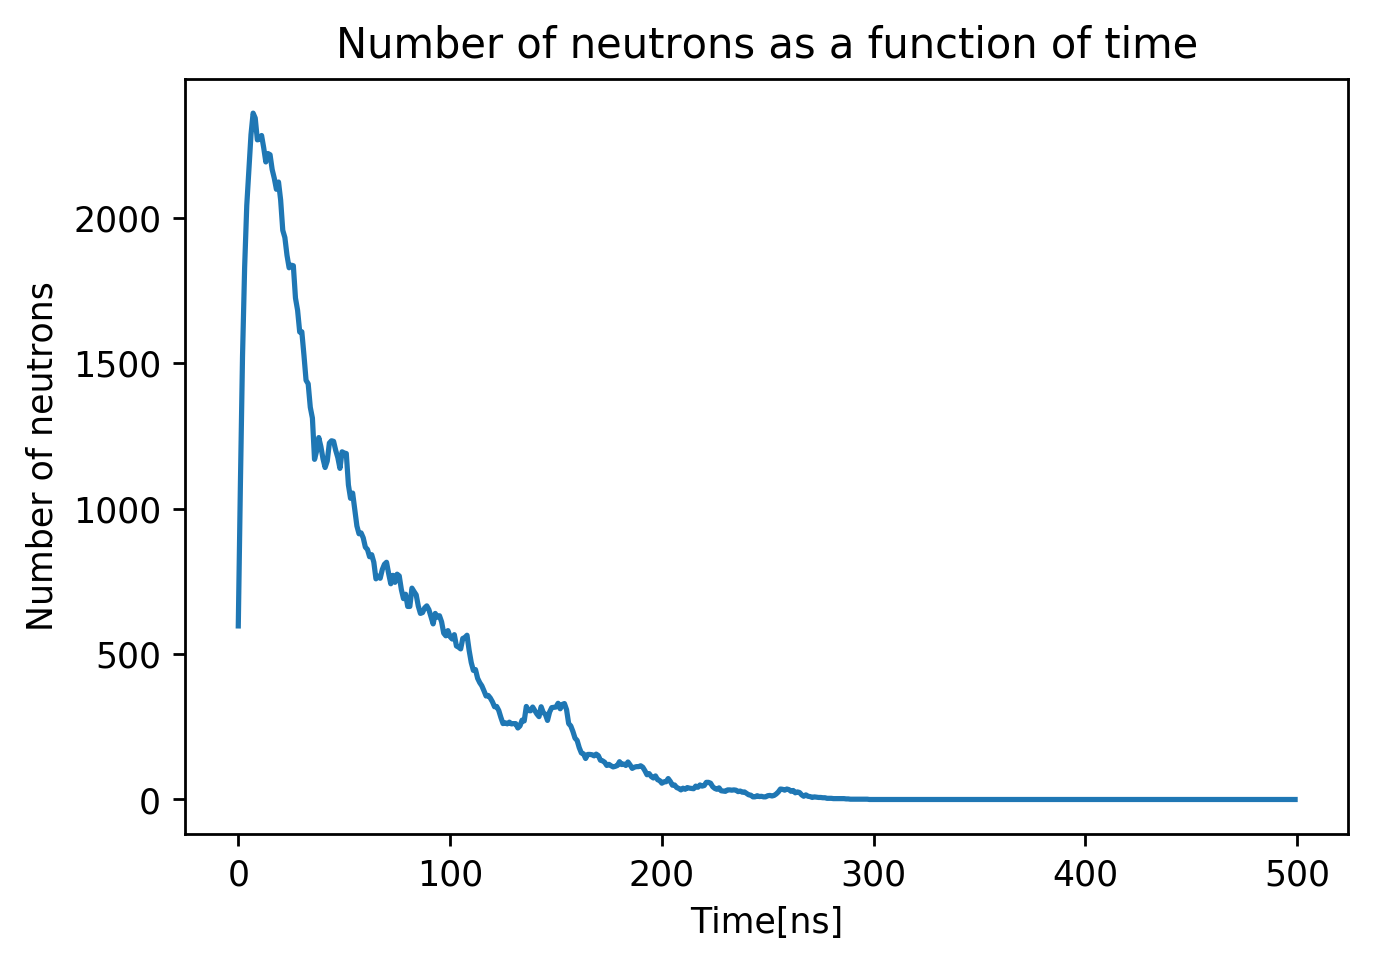

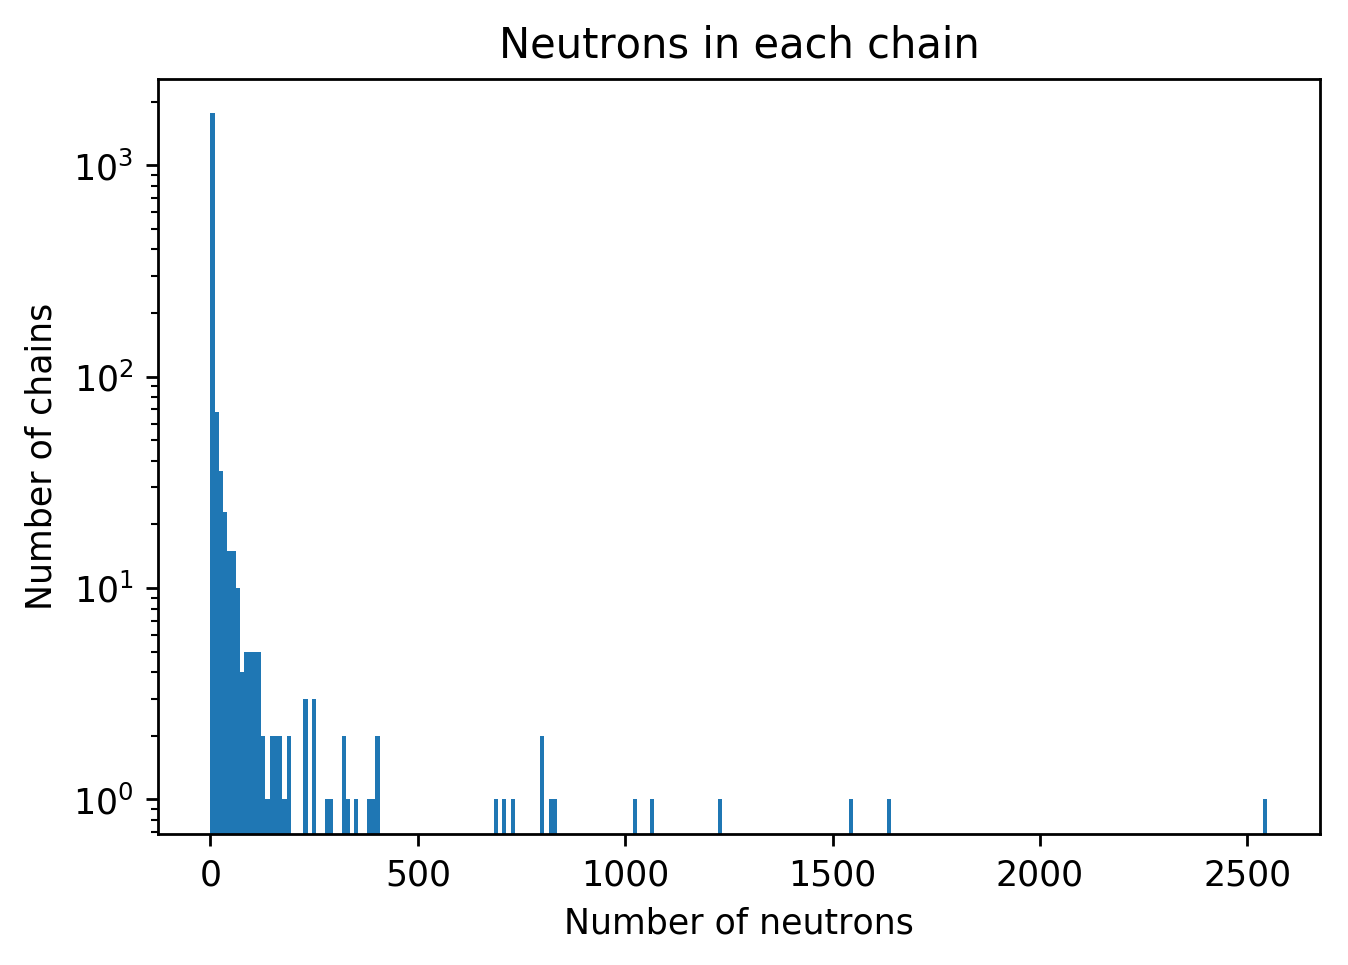

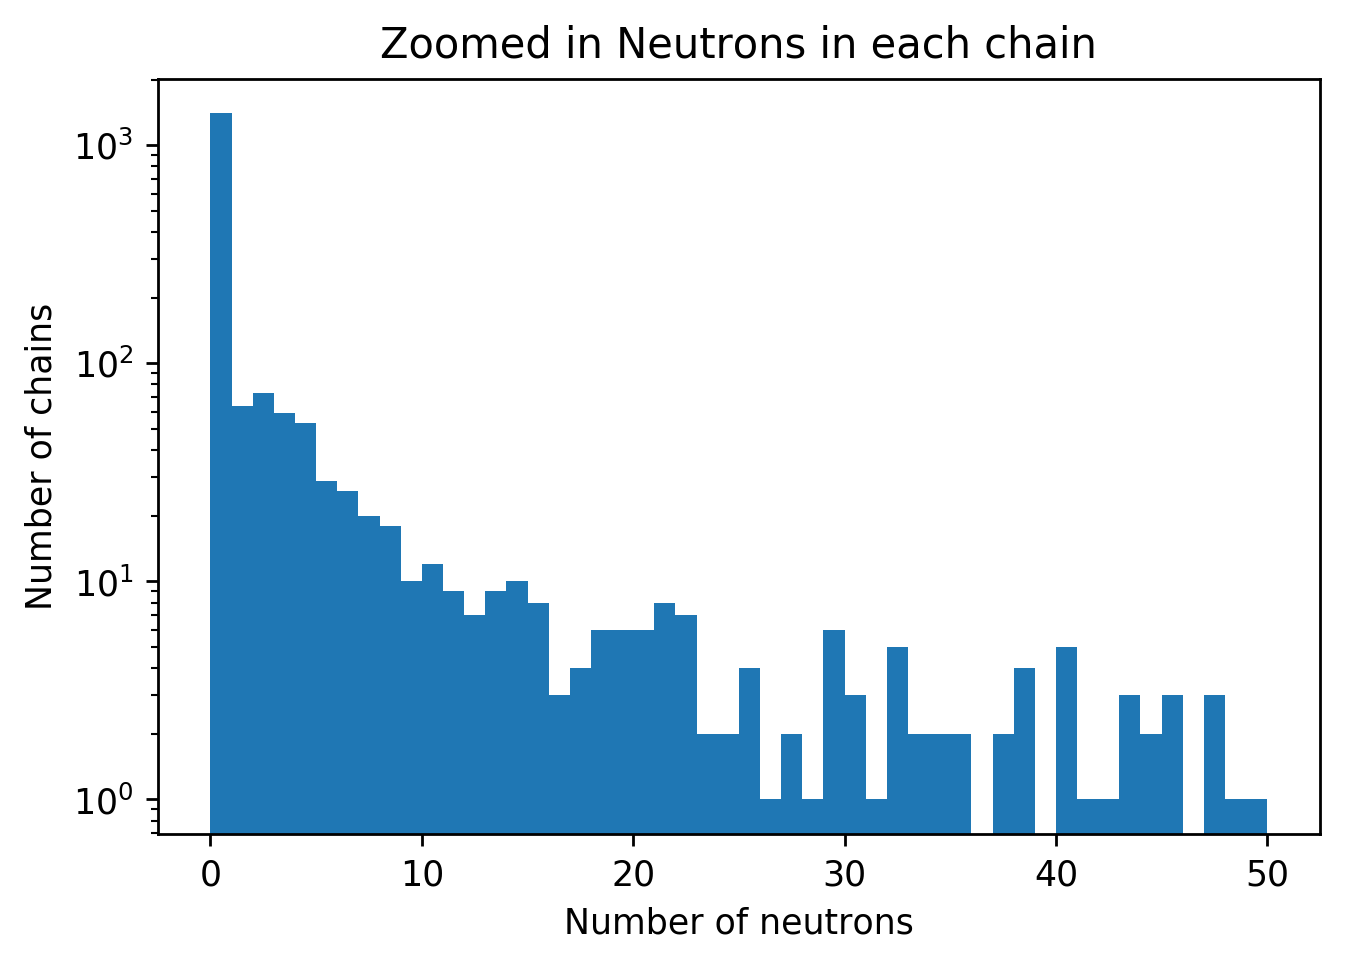

In [10]:
plt.figure()
plt.plot(trange,neutrons)
plt.title ('Number of neutrons as a function of time')
plt.xlabel('Time[ns]')
plt.ylabel('Number of neutrons')
plt.figure()
plt.hist(number,250)
plt.title("Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
plt.figure()
plt.hist(number,50,range=(0,50))
plt.title("Zoomed in Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
print('Number of neutrons', np.sum(number))

Increasing the radius is probably a little more effective.  

In [11]:
fmc.geo.radius=8.5
fmc.geo.height=26.0

print('Mass is',np.pi*fmc.geo.radius**2*fmc.geo.height*1e-3*fmc.geo.mat.density)

exitPositions=[] # where neutrons leave the sphere
startPositions=[] #where mothers are generated
fissionPositions=[] #where fissions occur
number=[]  #number of neutrons


fmc.Neutron.output=False #turn off print statements

trange=np.arange(0,fmc.Neutron.maxTime, fmc.Neutron.timeBin)
neutrons=np.zeros(fmc.Neutron.numberOfBins)

for run in range(1,2000):
#    pdb.set_trace()
    n.TrackNeutrons(10000000)
    startPositions.append(cylindrical(fmc.Neutron.firstNeutronStartPosition))
    count=0
    for i in range (0,fmc.Neutron.numberOfBins):
        for j in range(0,len(fmc.Neutron.list[i])):
            count+=1
            nn=fmc.Neutron.list[i][j]
            d=nn.nDaughters
            if 'escape' in d:
                exitPositions.append(cylindrical(nn.position))
            else:
                fissionPositions.append(cylindrical(nn.position))
            #now increment the neutrons versus time
            t1=int(nn.time0/fmc.Neutron.timeBin)
            t2=int(nn.time/fmc.Neutron.timeBin)+1
            if t1>=fmc.Neutron.numberOfBins:
                t1=fmc.Neutron.numberOfBins-1
            if t2>fmc.Neutron.numberOfBins:
                t2=fmc.Neutron.numberOfBins
            for t in range(t1,t2):
                neutrons[t]+=1
    
    number.append(count)
    if run%5 ==0:
        print('Run #',run)

#now we convert the lists into np arrays with rows corresponding to r, ctheta,phi
startPositions=np.array(startPositions).transpose()
exitPositions=np.array(exitPositions).transpose()
fissionPositions=np.array(fissionPositions).transpose()
number=np.array(number)



Mass is 111.29748343806966
Run # 5
Run # 10
Run # 15
Run # 20
Run # 25
Run # 30
Run # 35
Run # 40
Run # 45
Run # 50
Run # 55
Run # 60
Run # 65
Run # 70
Run # 75
Run # 80
Run # 85
Run # 90
Run # 95
Run # 100
Run # 105
Run # 110
Run # 115
Run # 120
Run # 125
Run # 130
Run # 135
Run # 140
Run # 145
Run # 150
Run # 155
Run # 160
Run # 165
Run # 170
Run # 175
Run # 180
Run # 185
Run # 190
Run # 195
Run # 200
Run # 205
Run # 210
Run # 215
Run # 220
Run # 225
Run # 230
Run # 235
Run # 240
Run # 245
Run # 250
Run # 255
Run # 260
Run # 265
Run # 270
Run # 275
Run # 280
Run # 285
Run # 290
Run # 295
Run # 300
Run # 305
Run # 310
Run # 315
Run # 320
Run # 325
Run # 330
Run # 335
Run # 340
Run # 345
Run # 350
Run # 355
Run # 360
Run # 365
Run # 370
Run # 375
Run # 380
Run # 385
Run # 390
Run # 395
Run # 400
Run # 405
Run # 410
Run # 415
Run # 420
Run # 425
Run # 430
Run # 435
Run # 440
Run # 445
Run # 450
Run # 455
Run # 460
Run # 465
Run # 470
Run # 475
Run # 480
Run # 485
Run # 490
Run # 495
Run

Number of neutrons 57495


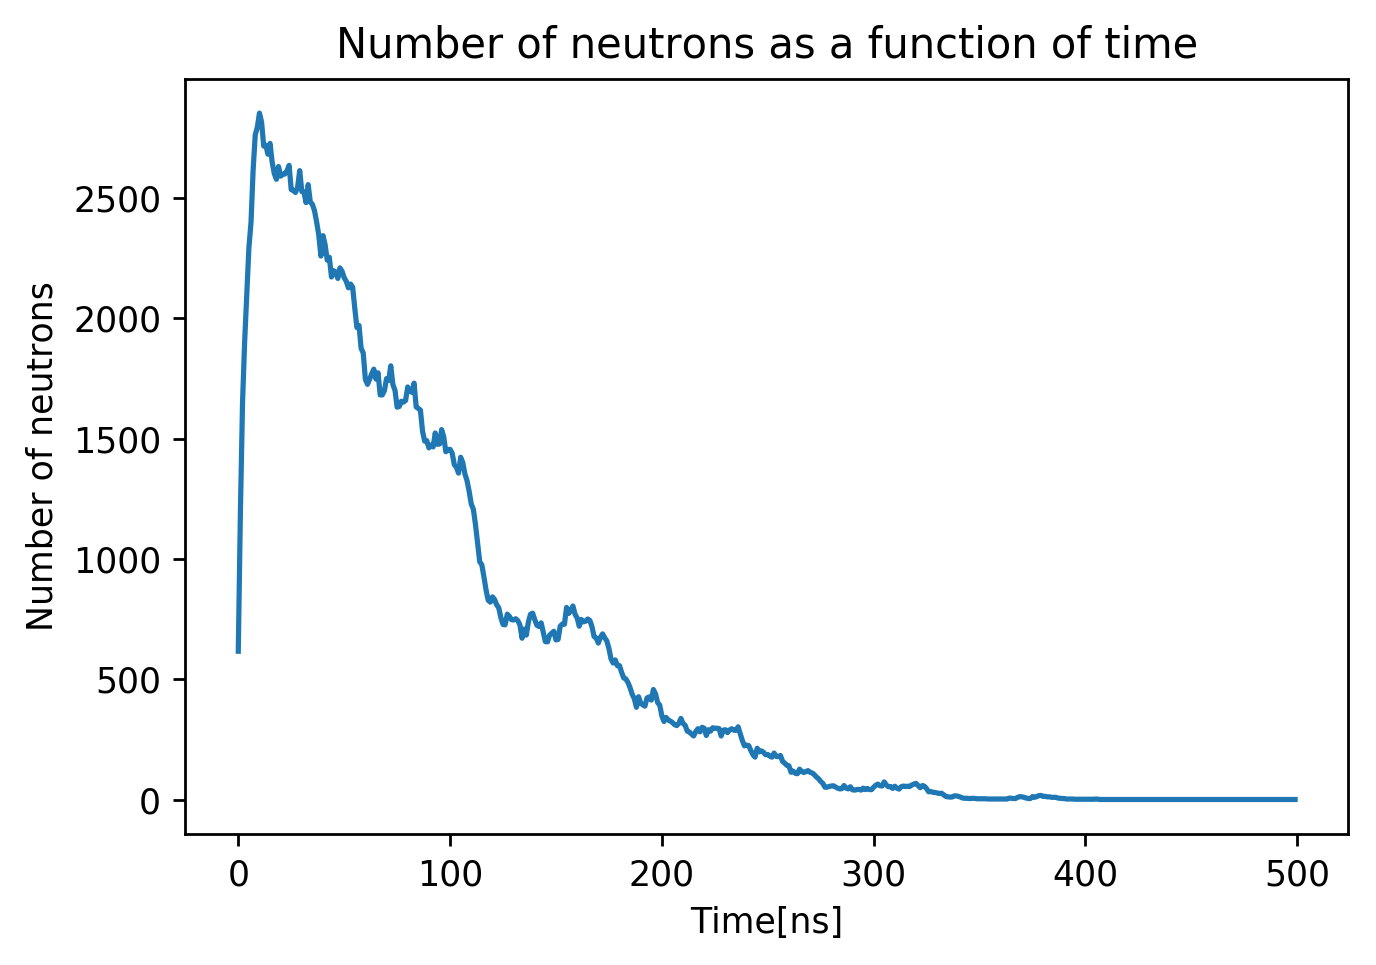

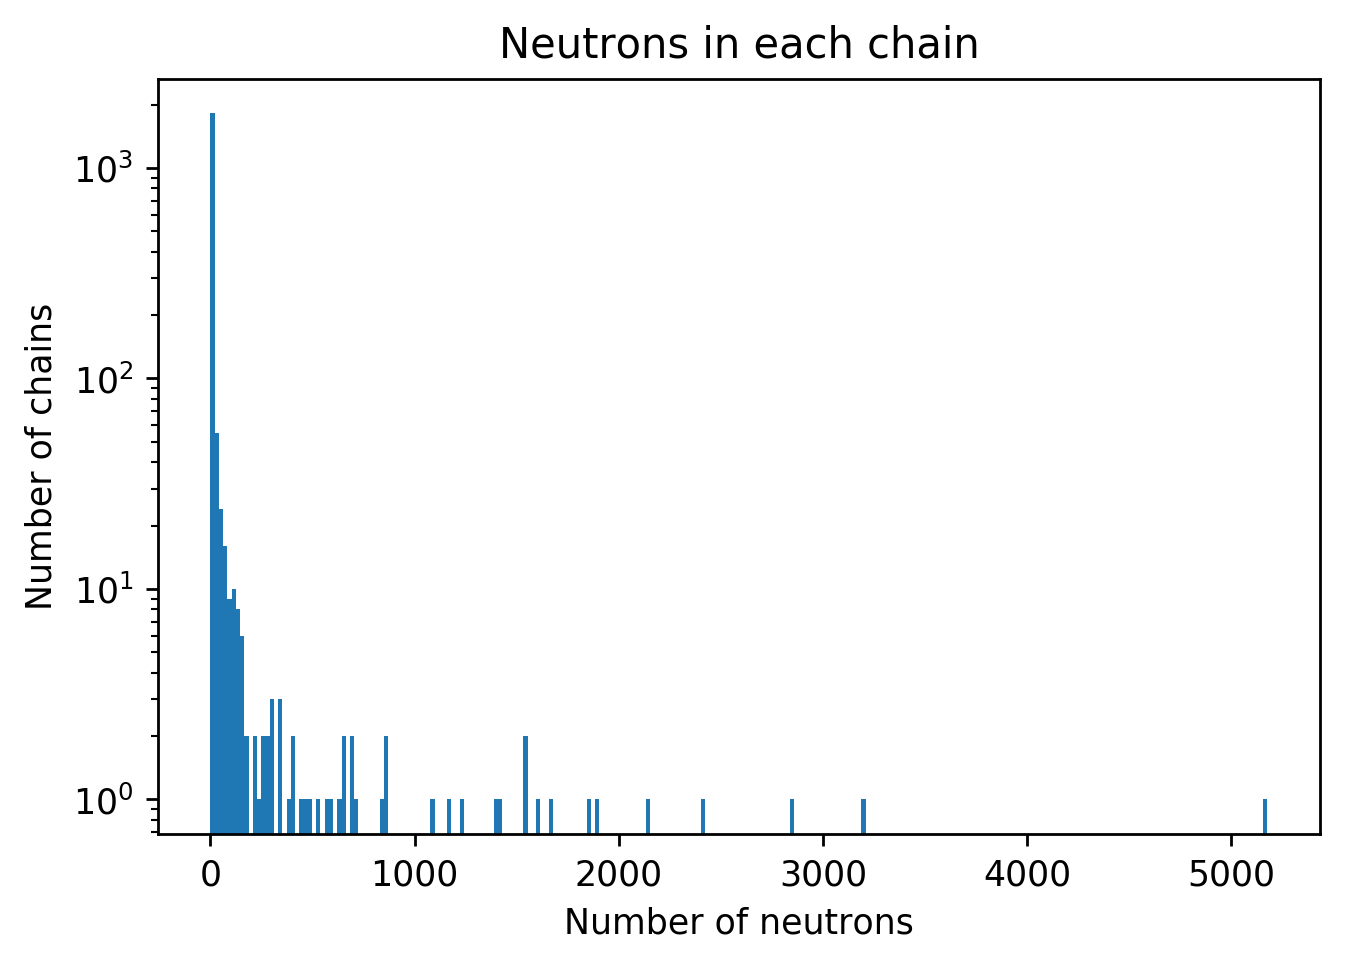

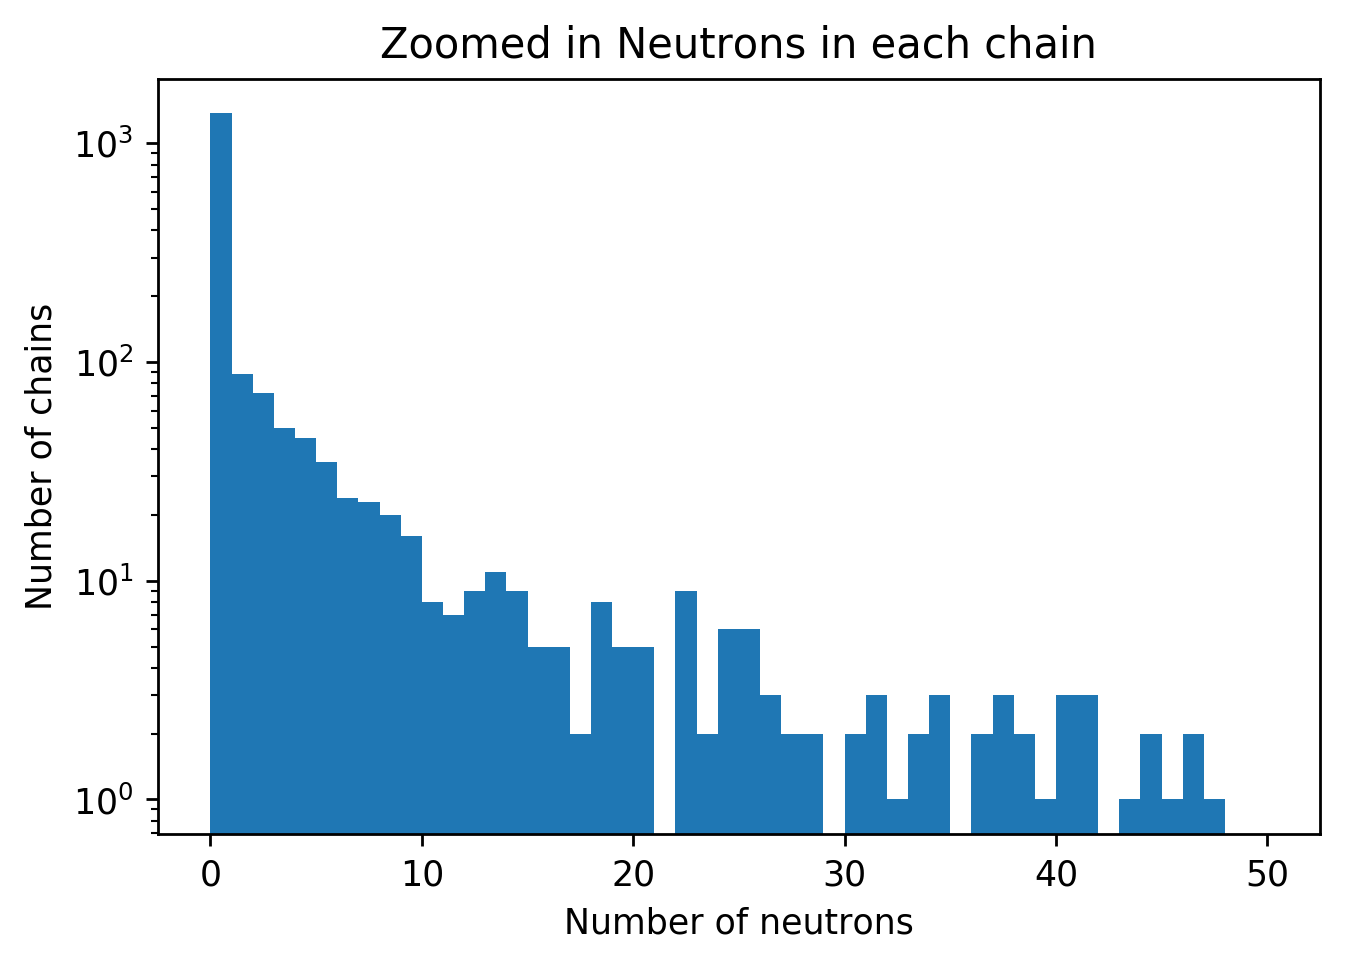

In [12]:
plt.figure()
plt.plot(trange,neutrons)
plt.title ('Number of neutrons as a function of time')
plt.xlabel('Time[ns]')
plt.ylabel('Number of neutrons')
plt.figure()
plt.hist(number,250)
plt.title("Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
plt.figure()
plt.hist(number,50,range=(0,50))
plt.title("Zoomed in Neutrons in each chain")
plt.xlabel("Number of neutrons")
plt.ylabel("Number of chains")
plt.yscale('log')
print('Number of neutrons', np.sum(number))

So the critical mass in this configuration is, not surprisingly, quite different.  

It should be evident that "inheritance" lets us modify class behaviour in a very organized way.


## Geometry Tools:  finding projections or intersections of arbitrary objects 

In assignment 3, we considered a shell with a cross section as shown:

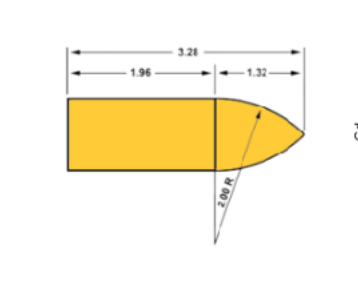

The problem will be to a) find the center of mass of the object
b)  Calculate intersections of arbitrary lines with the object
c)  Project the object onto an arbitrary plane.

We describe the object in terms of its axis $\hat{a}$, the diameter $d$, in terms of which all the other parameters are given:  the height of the cylinder is $h_c=1.96d$, $r_{tip}=2d$.  The 1.32 is redundant, since $\sqrt{2^2-1.5^2}=1.32$.

The volume:
\begin{equation} V=\int_0^{1.32}\int_0^{\sqrt{4-z^2}-1.5}2\pi\rho d\rho dz \end{equation}

where we use the fact that the boundary of the tip is given by $(\rho+1.5)^2+z^2=4$, and we have place $z=0$ at the intersection between the tip section and the cylinder section.

The $\rho$ integral is trivial analytically and so we do it:
\begin{equation} V=\int_0^{1.32}\pi\rho^2|_0^{\sqrt{4-z^2}-1.5} dz =\int_0^{1.32}\pi(\sqrt{4-z^2}-1.5)^2 dz  \end{equation}

This is also analytic, but we will just do it numerically.


In [9]:
from scipy import integrate

def rho(z):
    return np.pi*(np.sqrt(4-z**2)-1.5)**2

hc=1.96  #diameters- the height of the cylinder
rc=0.5  #diameters-- the radius of the cylinder
Vtip=integrate.romberg(rho,0,1.32)
print('tip volume is',Vtip)

Vbase=np.pi*rc**2*hc
print('base volume is',Vbase)

V=Vtip+Vbase

tip volume is 0.57622986698
base volume is 1.5393804002589986


We can easily find the center of mass by:
\begin{equation}z_{cm}=\frac{\int_0^{1.32}\int_0^{\sqrt{4-z^2}-1.5}z2\pi\rho d\rho dz}{V}   \end{equation}

In [14]:
def zrho(z):
    return z*np.pi*(np.sqrt(4-z**2)-1.5)**2

z_cmtip=integrate.romberg(zrho,0,1.32)/Vtip
print('tip center of mass',z_cmtip)


z_cm=(z_cmtip*Vtip-0.5*hc*Vbase)/V
print('center of mass',z_cm, 'volume=',V)

tip center of mass 0.425935749985
center of mass -0.59706454977 volume= 2.11561026724


## Intersections of lines with the object

Whenever you do geometry, use 3-vector algebra.

We define the "point" on the line as $\vec{x_0}$, and location of the shell (the point on the axis between the tip and the cylinder) as $\vec{x_s}$, the direction of the line  as $\hat{n}$ and the axis of the shell as $\hat{a}$.  

For this problem- especially since we want to work out the projections later it is easiest to work a coordinate system where $\hat{k}=\frac{\hat{n}\times\hat{a}}{|\hat{n}\times\hat{a}|}$,$\hat{j}\equiv\hat{a}$, and $\hat{i}=\hat{j}\times\hat{k}$.

This doesn't work if $\hat{n} \parallel \hat{a}$, in that case we put $\vec{x_0}$ on the x-axis if it has non-zero length;if it has zero length we pick an arbitrary x axis.

Notice that in this coordinate system, the line has a constant z-coordinate, since the direction of motion is perpendicular to the normal.  Thus, if $|z|>r$ there can be no intersection.
If $|z|<=r$, the intersection of the cylinder with the plane becomes a rectangle with length 1.96d, oriented along the y-axis and width $2\sqrt{r^2-z^2}$, and the tip is represented by two arcs.  We work these out by looking at the equation of a circle in the x-z plane: $x^2+z^2=\rho^2$, with a $(\pm\rho+1.5)^2+y^2=r_{tip}^2$.  

In this plane the line is represented by the equation $(x_{0p},y_{0p})+d(n_x,n_y)$.

There are five curves we check intersections of- the 3 line segments representing the cylinder and the two arcs.

We find the intersections of the line with the cylinder faces:
\begin{equation} -h_c=y_{0p}+dn_y \rightarrow d=\frac{-h_c-y_{0p}}{n_y} \end{equation}
\begin{equation} \sqrt{r^2-z^2}=x_{0p}+dn_x \rightarrow d=\frac{\sqrt{r^2-z^2}-x_{0p}}{x_y} \end{equation}
\begin{equation} -\sqrt{r^2-z^2}=x_{0p}+dn_x \rightarrow d=\frac{-\sqrt{r^2-z^2}-x_{0p}}{x_y} \end{equation}

For the two arcs, we solve the equation:
\begin{equation} \left(\pm\sqrt{(x_{0p}+dn_x)^2+z^2}+ 1.5\right)^2+(y_{0p}+dn_y)^2=r_{tip}^2\end{equation}

where the + sign corresponds to the -x arc, and the - sign to the +x arc.

To solve this equation, we make use of the scipy.optimize.root function.

This could give us seven possible values for the distance to the interaction, $d$, but only two can be physical (ie.  have an intersection that occurs between the endpoints); for $\vec{x_c}$ inside the shell one of them will be negative and the other positive.  

We write a routine that returns the positive d values, sorted, given the starting point and direction.


In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
from scipy import optimize
#define shell coordinates.  We have already done some, but we want them all in one place.

hc=1.96  #length of shell
r=0.5  #radius of shell
rtip=2 # radius of curvature of the tip.
offset=rtip-r  #distance from center of shell to center of circle

#pick x0 along z axis and at -20
x0=np.array([0,0,-20])

#the center of the shell is defined as the point on the axis of the cylinder on the face between the cylinder and the 
#tip.
xs=np.array([0,0,0])

def intersection(x0,n):
#    import pdb; pdb.set_trace()
    j=a
    k=np.cross(n,a)  #z axis
    if np.linalg.norm(k)==0: #line is parallel to cylinder
        if np.linalg.norm(x0)==0:
            k=np.random.rand(3)  #a random vector.  In principle we should test to make sure this is still parallel
            #to j, but the chances are incredibly small so we will risk it!
        else:
            k=x0
        k=k-(np.dot(k,j))*j

    k=k/np.linalg.norm(k)  #unit vector, perpendicular to axis.
    i=np.cross(j,k)
    
    #z is the constant plane offset
    xsp=x0-xs  # xs is the origin of the shell coordiate system
    
    z=np.dot(xsp,k)
    x0p=np.dot(xsp,i)
    y0p=np.dot (xsp,j)
    nx=np.dot(n,i)
    ny=np.dot(n,j)
               
    d=[] #the solutions
    if abs(z)<r:  #there are possible intersections
        hwidth=np.sqrt(r**2-z**2)  #width of rectangle for intersections
#        rcirc=offset+hwidth
        if ny!=0:
            dtest=(-hc-y0p)/ny
            xtest=dtest*nx+x0p
            if abs(xtest)<hwidth and dtest>=0:  #do we hit within the line segment
                d.append(dtest)
        if nx!=0:
            dtest=(-hwidth-x0p)/nx
            ytest=dtest*ny+y0p
            if ytest<0 and ytest>-hc and dtest>=0:
                d.append(dtest)
            dtest=(hwidth-x0p)/nx
            ytest=dtest*ny+y0p
            if ytest<0 and ytest>-hc and dtest>=0:
                d.append(dtest)

        dtip0=np.linalg.norm(xsp)
        dtip=optimize.root(tipFunction,dtip0,(x0p,y0p,z,nx,ny,rtip,offset,-1.0))
#        dtip0=np.roots([1, 2*(nx*(x0p+offset)+ny*y0p),(x0p+offset)**2+y0p**2-rcirc**2])
#        for dtest in dtip:
#            if not np.iscomplex(dtest):
        if dtip.success:
            dtest=dtip.x
            x=x0p+nx*dtest
            y=y0p+ny*dtest
            if y>=0 and x>=0 and x<=hwidth and dtest>=0 and y<1.32:
                d.append(dtest)

        dtip=optimize.root(tipFunction,dtip0,(x0p,y0p,z,nx,ny,rtip,offset,1.0))        
#        dtip=np.roots([1, 2*(nx*(x0p-offset)+ny*y0p),(x0p-offset)**2+y0p**2-rcirc**2])
#        for dtest in dtip:
#            if not np.iscomplex(dtest):
        if dtip.success:
            dtest=dtip.x
            x=x0p+nx*dtest
            y=y0p+ny*dtest
            if y>=0 and x<=0 and x>=-hwidth and dtest>=0 and y<1.32:
                d.append(dtest)
    if len(d)>2:
        print('too many solutions',d)
    elif len(d)==2:
        if d[0]>d[1]:
            d[1],d[0]=d[0],d[1]
    return d

def tipFunction(d,*args):
    x0p,y0p,z,nx,ny,rtip,offset,sign=args
    return (sign*np.sqrt((x0p+d*nx)**2+z**2)+offset)**2+(y0p+d*ny)**2-rtip**2

thetamax=np.arctan(hc*1.1/np.linalg.norm(xs-x0))
ctmax=1-np.cos(thetamax)

#let's throw random direction for the shell axis
phi=np.pi*2*np.random.rand()
ct=2*np.random.rand()-1
ct=0  #over write to test
phi=0  #overwrite phi to test
st=np.sqrt(1-ct**2)
a=np.array([st*np.cos(phi),st*np.sin(phi),ct])  #axis of the shell

#repeat for the line direction
phi=np.pi*2*np.random.rand()
ct=2*np.random.rand()-1
st=np.sqrt(1-ct**2)
n=np.array([st*np.cos(phi),st*np.sin(phi),ct])

print('ctmax=',ctmax)

ctmax= 0.00576026400779


In [11]:
# now generate random directions until we end up with an intersection
sol=[]

while len(sol)==0:
    phi=np.pi*2*np.random.rand()
    ct=1-ctmax*np.random.rand()  
    st=np.sqrt(1-ct**2)
    n=np.array([st*np.cos(phi),st*np.sin(phi),ct])

    sol=intersection(x0,n)
print(sol)

[array([ 19.64500564])]


In [61]:

#a=(1,0,0) #shell orientation

#let's throw random direction for the shell axis
phi=np.pi*2*np.random.rand()
ct=2*np.random.rand()-1
st=np.sqrt(1-ct**2)
a=np.array([st*np.cos(phi),st*np.sin(phi),ct])  #axis of the shell

#a=(1,0,0)



To validate, we generate a few thousand random directions, and plot the intersections:

In [62]:
#define a rotation matrix to transform to a shell-centered coordinate system:
j=a
k=np.cross((x0-xs),j)
k=k/np.linalg.norm(k)
i=np.cross(j,k)
m=np.array([i,j,k])
rot=np.array([i,j,k]).transpose()   # now vector*rot will be in i,j,k coordinates
spatial=True # false for line illumination; true for complete 3d uniformity
#import pdb;pdb.set_trace()
points=[]
while len(points)<1000:
    if spatial:
        phi=np.pi*2*np.random.rand()
        ct=1-ctmax*np.random.rand()
        st=np.sqrt(1-ct**2)
        n=np.array([st*np.cos(phi),st*np.sin(phi),ct])
    else:  #throw a line at constant x
        phi=0.2*(np.random.rand()-0.5)
        n=np.array([np.sin(phi),0,np.cos(phi)])
    sol=intersection(x0,n)
    if len(sol)>0:
        x=x0+n*sol[0]
        points.append(x)
#    if len(points)%50==0:
#        print('Generated %d events'%(len(points)))
points=np.array(points)

In [63]:
p2=np.dot(points,rot)  #to check intersections in "shell coordinate systme"
points=points.transpose()
p2=p2.transpose()

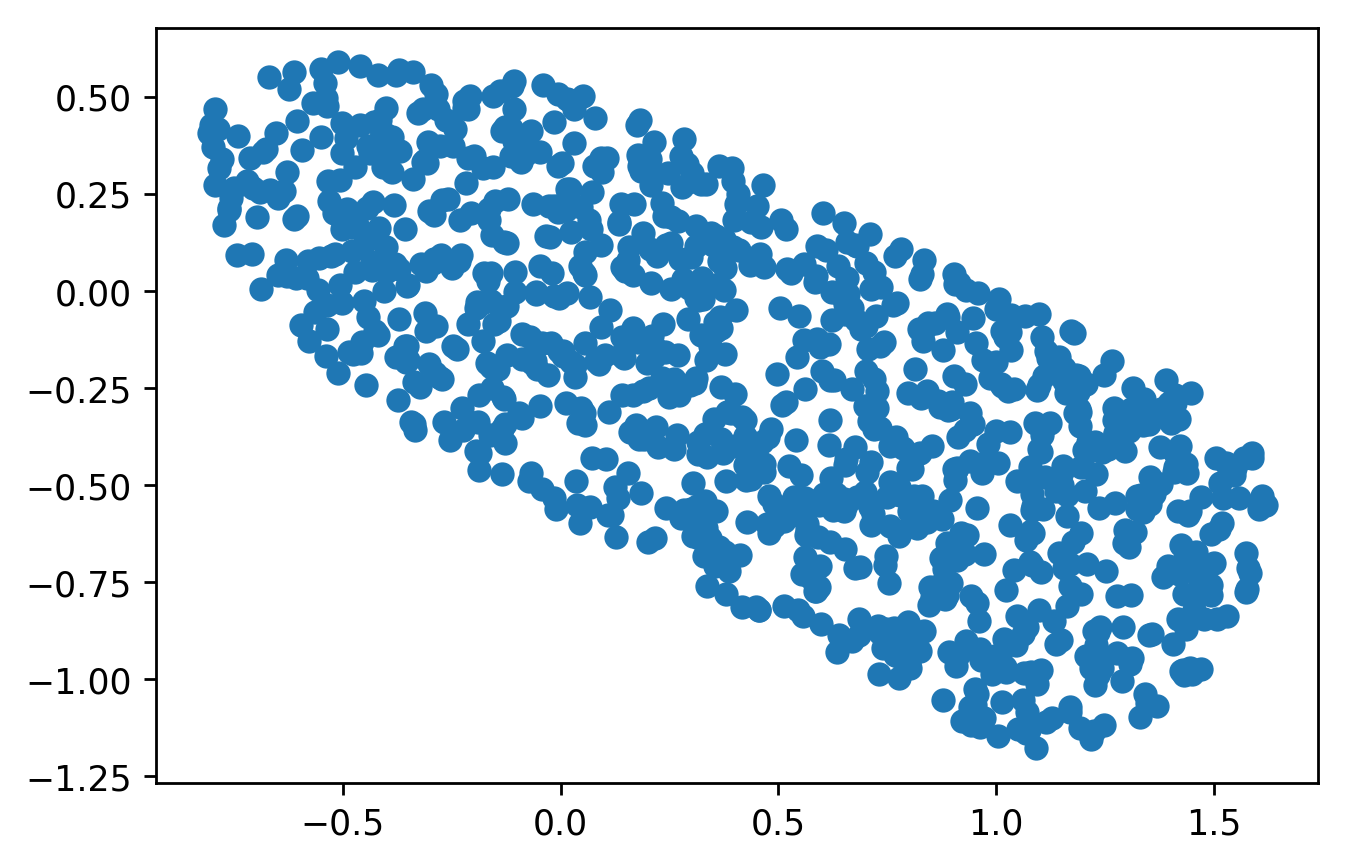

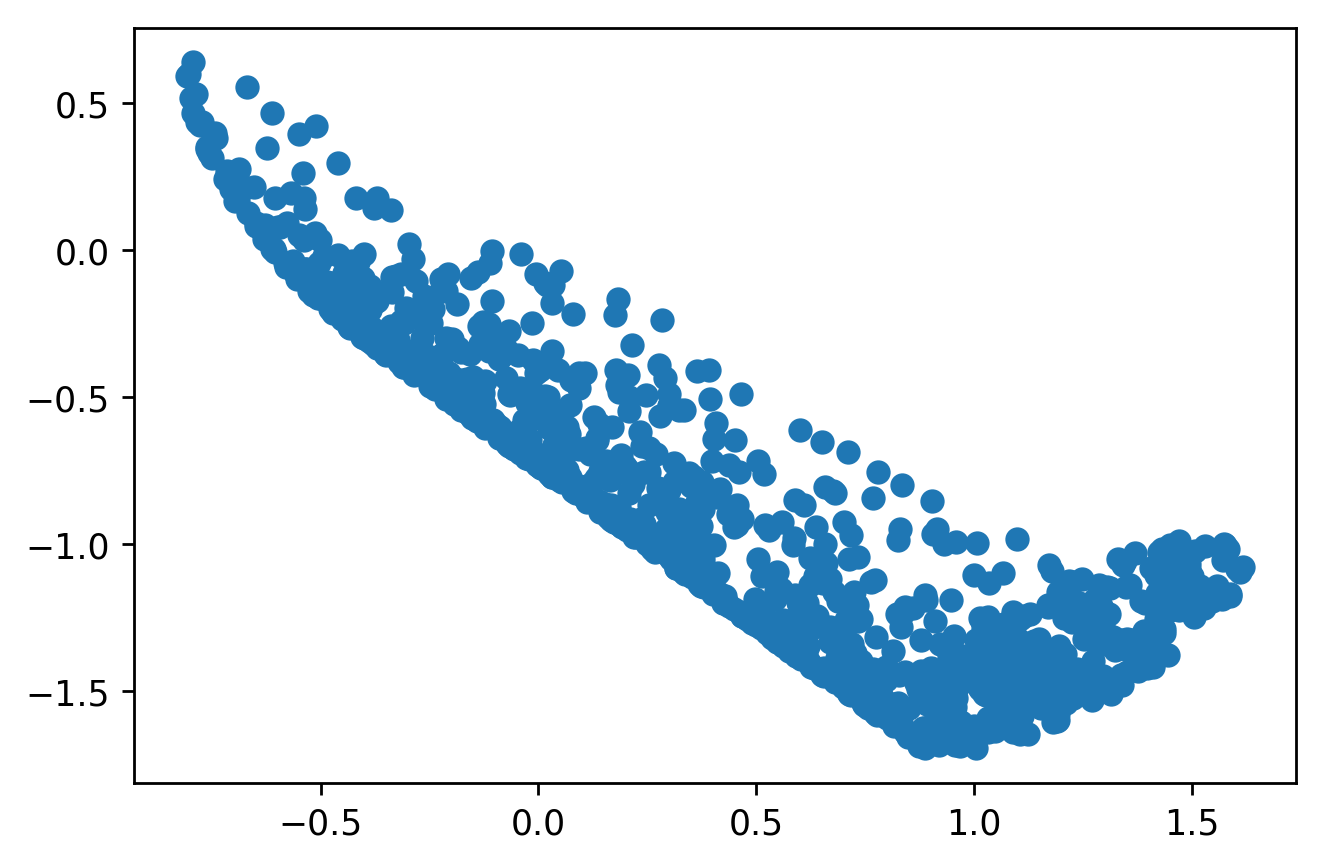

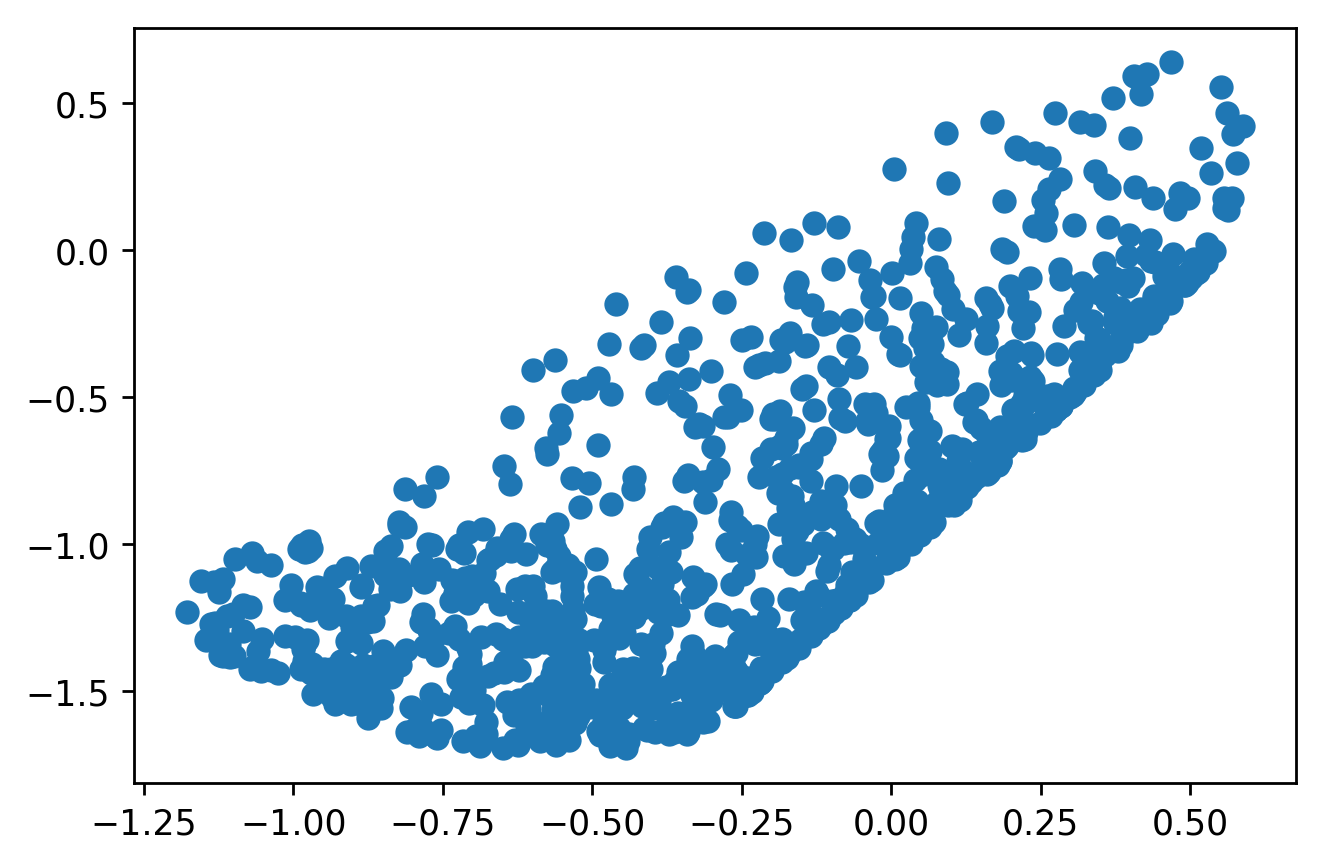

In [64]:
plt.figure()
plt.plot(points[0],points[1],'o')
plt.figure()
plt.plot(points[0],points[2],'o')
plt.figure()
plt.plot(points[1],points[2],'o')


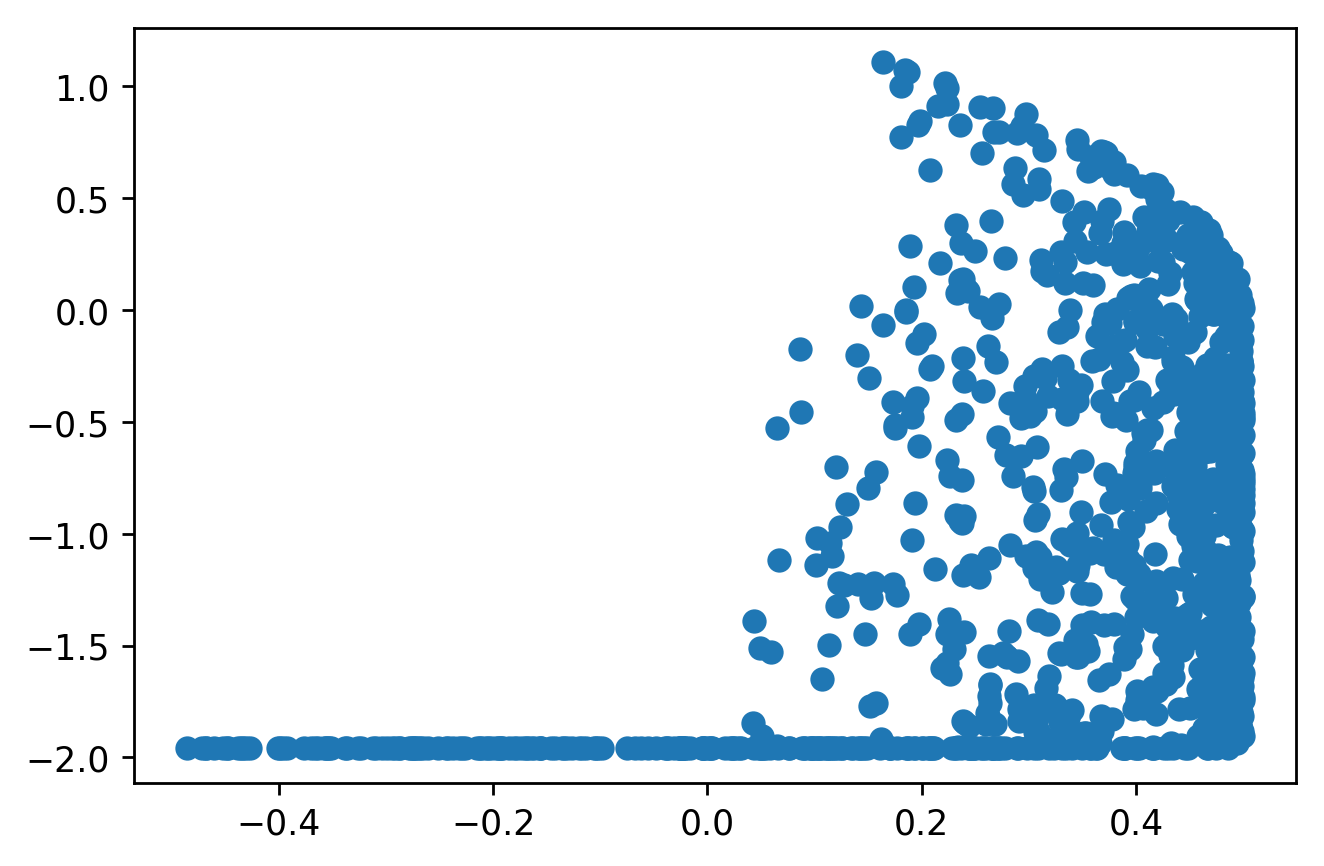

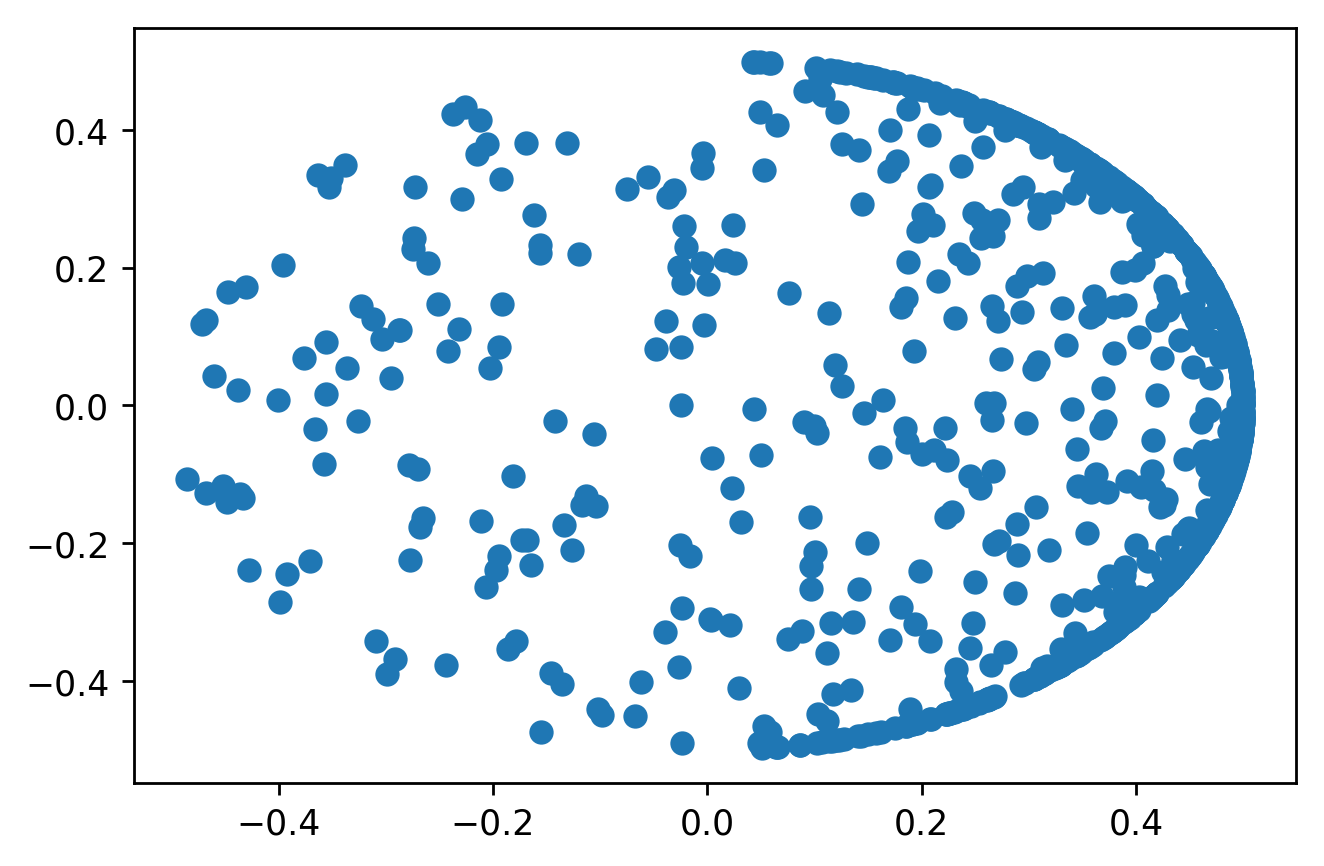

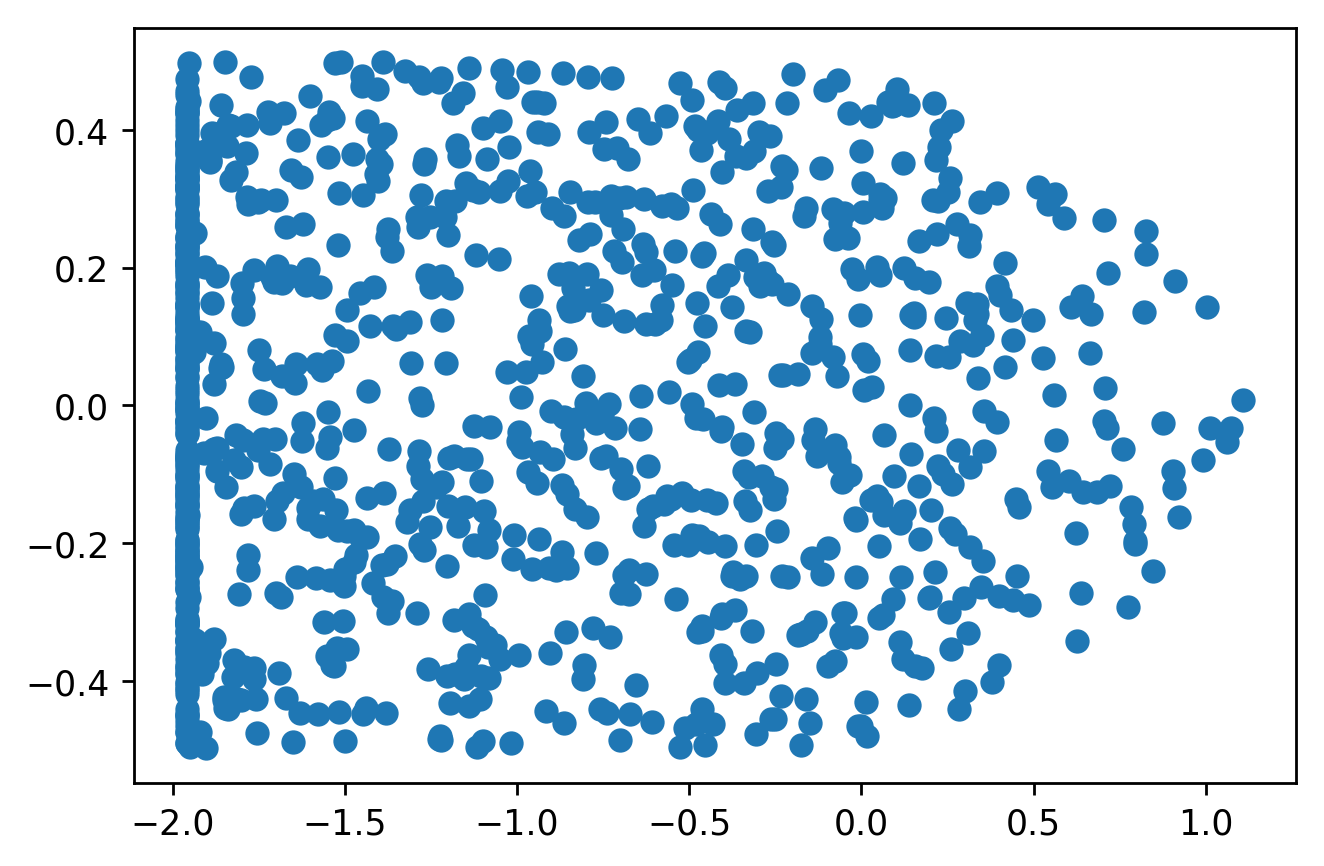

In [65]:
plt.figure()
plt.plot(p2[0],p2[1],'o')
plt.figure()
plt.plot(p2[0],p2[2],'o')
plt.figure()
plt.plot(p2[1],p2[2],'o')


## The Projection

To calculate the projection we can use much of the same code. To make the projection, we want to find the set of all points $\vec{x}$ such that $\vec{x}+d\hat{n}$ intersects the shell, for $\hat{n}$ the normal vector to the plane onto which we are projecting and for some distance $d$.  Therefore, we can test whether a point $\vec{x}$ on a plane with normal $\hat{n}$ is an element of the projection by calling intersection(x,n)- if there are solutions then we are in the projection.  We could sample points either by doing a "bit-by-bit" raster scan, which we would do if we wanted to make an image, or by MC.  

However, it is a little more elegant to define points (x,y) which make up the boundary of the projection on the plane.  These can be used in a straightforward way to draw a path corresponding to the edge of the object.  That is not much more complicated- for any x, we want to find the minimum and maximum values of y that correspond to the limits of the intersection. We will go into a reference frame with a constant z- offset, and for a constant x find the maximum and minimum y, by checking there are five points we need to consider- the "corners" in the plane, and also to see if the curved line gives a maximum.  

But before starting to calculated ranges, we start by setting up how to plot the projection.  What we will do is put together a list of (x,y) coordinates for points around the boundary of the projection. Let's assume a projection is defined by five points- (0,1),(0,3),(1,3),(2,4),(-1,5).  How do we draw the projection?


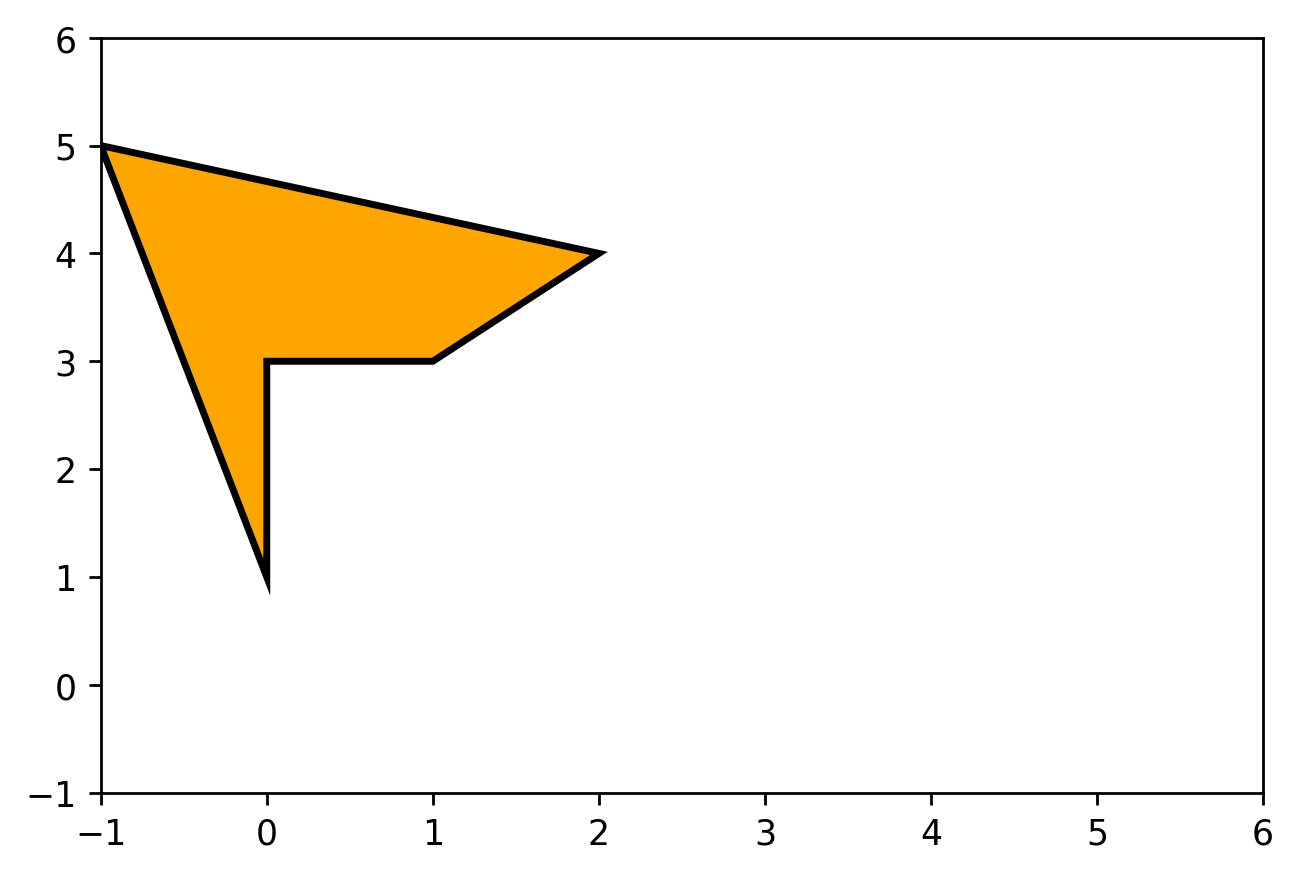

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [(0,1),(0,3),(1,3),(2,4),(-1,5), (0,0)]  # we need to add an extra vertex to "close" the path
codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]
path = Path(verts, codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-1,6)
ax.set_ylim(-1,6)
plt.show()



Now we make a projection method.  

Without loss of generality, we define the x and y axis as the coordinates in the plane onto which we are going to project.  

There are actually 7 points we need to calculate for each value of z, and the projection will include all points between the minimum and the maximum.  

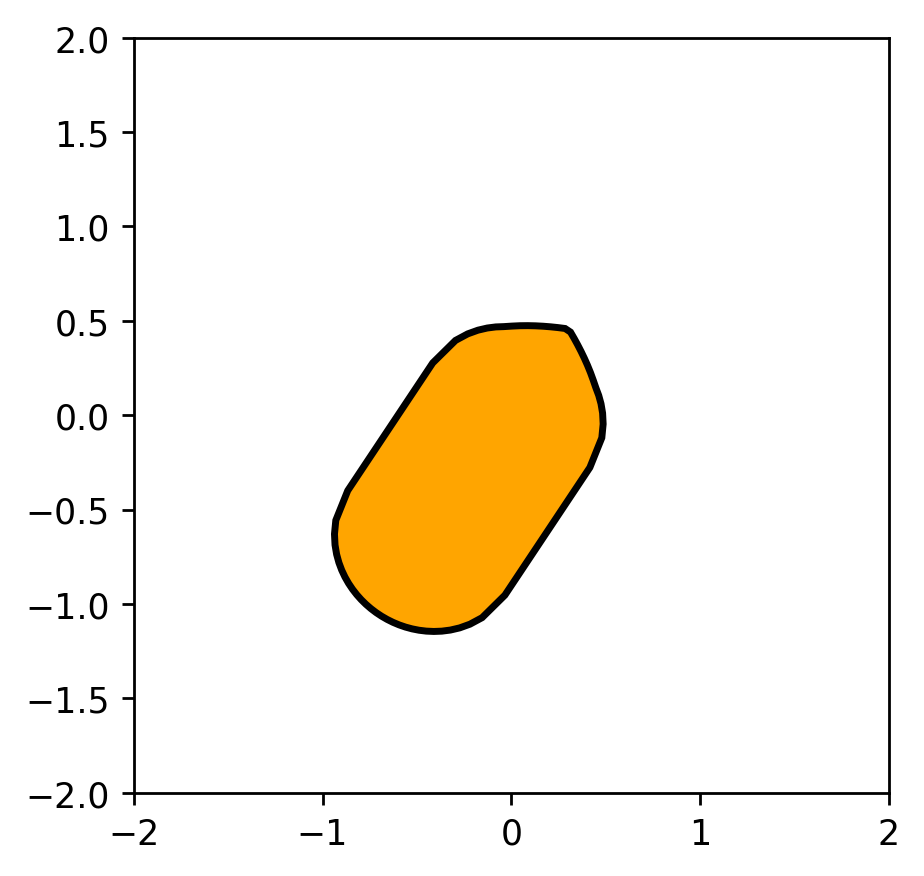

In [16]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
from matplotlib.path import Path
import matplotlib.patches as patches

from scipy import optimize
#define shell coordinates.  We have already done so, but we want them all in one place.

hc=1.96  #length of shell
r=0.5  #radius of shell
rtip=2 # radius of curvature of the tip.
offset=rtip-r  #distance from center of shell to center of circle



#the center of the shell is defined as the point on the axis of the cylinder on the face between the cylinder and the 
#tip.
xs=np.array([0,0,0])

def projection(count):
    '''This will return a list of count vertices (x,y), with a projection of the shell onto the plane.'''
    
    # find axes that correspond to z (distance from plane, j- along the shell axis and i)
    j=a
#    import pdb; pdb.set_trace()
    n=np.array([0,0,1])
    k=np.cross(n,a)  #z axis
    if np.linalg.norm(k)==0: #line is parallel to cylinder- projection is a circle of radius r
        phi=np.linspace(0,2*np.pi,count+1)
        projection=r*np.array([np.cos(phi),np.sin(phi)]).transpose()
    else:
        k=k/np.linalg.norm(k)  #unit vector, perpendicular to axis.
        i=np.cross(j,k)
        mat=np.array([i,j,k])
#        import pdb; pdb.set_trace()
        #we will also need a horizontal (ie parallel to projection plane) unit vector
#        if j[2]>=0:
##            horiz=(-j[2]*i+i[2]*j)/np.sqrt(i[2]**2+j[2]**2)
#        else: 
#            horiz=(j[2]*i-i[2]*j)/np.sqrt(i[2]**2+j[2]**2)
        
        nShell=np.array([np.dot(n,i),np.dot(n,j)])
        zlist=np.linspace(-r,r,int(count/2))
        v1=np.array([1,0,0])
        projection=np.empty([int(count+1),2])
        ict=0  # keeps track of vertex number
        for z in zlist:
            hwidth=np.sqrt(r**2-z**2)  # half width of rectangle for intersections
            rcirc=offset+abs(z)  
            # we transform the center of rotation so we can check for curved surface maxima/minima
            points=np.array(([-hwidth,-hc,z],[-hwidth,0,z],[0,np.sqrt(rtip**2-rcirc**2),z],
                            [hwidth,0,z],[hwidth,-hc,z],[offset,0,z],[-offset,0,z]))#7x3 array of points
            pxyz=np.dot(points,mat)  #transform from shell coordinates to x,y,z

            #check to see if we need to consider the curved surface corresponding to (x+offset)
            if 0<pxyz[5][2]<pxyz[2][2]:
                sol=optimize.root(ftip,0.5*(points[1,0:2]+points[2,0:2]),(z,offset,rtip,nShell))
#                print('sol5 =',sol,points)
                points[5,0:2]=sol.x
                pxyz[5]=np.dot(points[5],mat)
            else:
                pxyz[5]=pxyz[1]    
            if 0<pxyz[6][2]<pxyz[2][2]:
                sol=optimize.root(ftip,0.5*(points[3,0:2]+points[2,0:2]),(z,offset,rtip,nShell))
#                print('sol 6 =',sol,points)
                points[6,0:2]=sol.x
                pxyz[6]=np.dot(points[6],mat)
            else:
                pxyz[6]=pxyz[3]

            if abs(j[1])>abs(i[1]):
               arg=1
            else:
               arg=0
            ip1=np.argmin(pxyz[:,arg])
            ip2=np.argmax(pxyz[:,arg])
            
            projection[ict]=pxyz[ip1,0:2]
            projection[-2-ict]=pxyz[ip2,0:2]
            ict+=1
#            print('points',points)
#            print('pxyz',pxyz)
#            print('projection',projection)
#            print('ict',ict)
#            print('proj2',proj2)
    return projection

#function to solve for projection on curved surface.  Relies on z, offset (center of circle to center of shell), 
# rtip (radius of curvature of the shell), nShell (projection axis in Shell coordinates) having been defined 
def ftip(xarray,*args):
    z,offset,rtip,nShell=args
    x,y=xarray
    retval=(x**2+y**2+z**2+2*offset*np.sqrt(x**2+z**2)+offset**2-rtip**2, nShell[0]*x+nShell[1]*y)
    return np.array(retval)

#let's throw random direction for the shell axis
phi=np.pi*2*np.random.rand()
ct=2*np.random.rand()-1
ct=-0.91  #override
#phi=np.pi/2
st=np.sqrt(1-ct**2)
a=np.array([st*np.cos(phi),st*np.sin(phi),ct])  #axis of the shell

npoints=60
verts = projection(npoints)  #[(0,1),(0,3),(1,3),(2,4),(-1,5), (0,0)]  # we need to add an extra vertex to "close" the path
codes=Path.LINETO*np.ones(npoints+1)
codes[0]=Path.MOVETO
codes[-1]=Path.CLOSEPOLY
#codes = [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY]
path = Path(verts,codes)

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.axes().set_aspect('equal')  #make pixels equal in x and y dimensions
plt.show()


We could do the projection with the "intersection" routine- for each pixel in the x-y plane check to see if there is an intersection, and if so color it.

You can also do interesting things like change the value of the color depending upon the angle between the line and the surface.  This gives contrast, and makes the projection show the lines that correspond to borders between different faces.  

For simple shapes- flat faced objects, spheres, cylinders, etc.  my inclination would not be to "go into 2d" - but just solve the 3d equations outright (like we did for the sphere and the cylinder).  However, when the shapes are more complex than polynomials I would go into "shape-on-a-plane" coordinates.  


